## Modelling part 1: Reproducing the paper results

Expected results:
- SST (Sea Surface Temperature) (increase) influences hard corals negatively
- Photosynthetic active raditation (PAR) as well
- Wind speed helps cool down 
- UV radiance increase temperature
- Deep water helps coral from temperature 

In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

import data_processing_helper as dp
import practical_functions as pf

import warnings
warnings.filterwarnings("ignore")

In [81]:
df_data = pd.read_csv("../Data/merged_30_04.csv")
df_extended = pd.read_csv("../Data/merged_5_05_extended.csv")
df_data.drop(columns = "id", inplace = True)

df_extended## Treating the extended file 

Steps: 
- bound the variable to end with its corresponding date
- 


In [82]:
def bound_dates(df_extended, list_dates):
    df_concat = []
    end_col_wind = df_extended.columns.get_loc([col for col in df_extended.columns if "wind_" in col][-1]) + 1
    end_col_rad = df_extended.columns.get_loc([col for col in df_extended.columns if "rad_solar_2018-12" in col][0]) +1
    end_col_clear_rad = df_extended.columns.get_loc([col for col in df_extended.columns if "clear_rad_solar_" in col][-1]) +1
    end_col_DHW = df_extended.columns.get_loc([col for col in df_extended.columns if "DHW_" in col][-1])+ 1
    end_col_SST = df_extended.columns.get_loc([col for col in df_extended.columns if "SST_" in col][-1]) + 1
    for date in list_dates:
        df_date = df_extended[df_extended["surveydate"] == date]
        lend_date = [col for col in df_extended.columns if date in col]
        
        st_wind = df_extended.columns.get_loc(lend_date[0]) + 1
        st_rad = df_extended.columns.get_loc(lend_date[1]) + 1
        st_clear_rad = df_extended.columns.get_loc(lend_date[2])+1 
        st_DHW = df_extended.columns.get_loc(lend_date[3]) + 1
        st_SST = df_extended.columns.get_loc(lend_date[4]) +1
        
    
        
        df = df_date.iloc[:, np.r_[:st_wind, end_col_wind:st_rad, end_col_rad:st_clear_rad, end_col_clear_rad:st_DHW, end_col_DHW:st_SST]]
        df_concat.append(df)
        
        
    return pd.concat(df_concat)
        

        
    

In [83]:
list_dates = df_extended["surveydate"].unique()

In [84]:
# In this dataframe, the end dates for variables is in the start of the survey date (we don't know the future )
df_date_match = bound_dates(df_extended, list_dates)

### I want to add bleaching

In [85]:
bleach = gpd.read_file("../Data/Environmental_data/Bleaching/GBR_MTSRF-1-1-5_AIMS_Coral-bleaching_1998-2002.shp")

In [86]:
bleach_98 = bleach[bleach["year"] == 1998]
bleach_02 = bleach[bleach["year"] == 2002]

<AxesSubplot:>

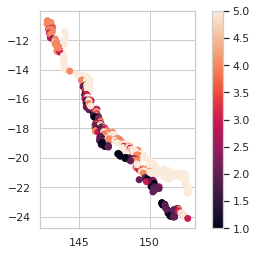

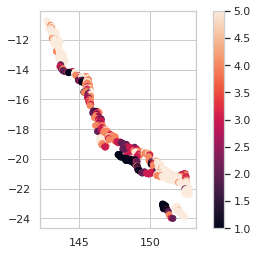

In [87]:
bleach_98.plot(column = "bleach",legend=True)
bleach_02.plot(column = "bleach",legend=True)

In [88]:
# lat lon geometry
df_date_match_AUS = df_date_match[df_date_match["country"] == "AUS"]
dp.geo_loads(df_date_match_AUS)
df_date_match_AUS = pf.make_geo_frame(df_date_match_AUS)

In [89]:
# lat lon geometry
bleach_98_swap = dp.swap_coordinates(bleach_98)
bleach_02_swap = dp.swap_coordinates(bleach_02)

In [90]:
near_bleach_98 = dp.nearest_neighbor(df_date_match_AUS, bleach_98_swap, return_dist=True)
near_bleach_02 = dp.nearest_neighbor(df_date_match_AUS, bleach_02_swap, return_dist=True)

# Give bleach a nan value for distances greater than 50 000 from survey 
near_bleach_98.loc[near_bleach_98["distance"] > 50000, 'bleach'] = np.nan
near_bleach_02.loc[near_bleach_02["distance"] > 50000, 'bleach'] = np.nan
near_bleach_98.rename(columns = {"bleach":"bleach_98"}, inplace = True)
near_bleach_02.rename(columns = {"bleach":"bleach_02"}, inplace = True)

In [91]:
# Weighted version of bleach by distance
near_bleach_98["bleach_weighted_1998"] = near_bleach_98["bleach_98"]/near_bleach_98["distance"]
near_bleach_02["bleach_weighted_2002"] = near_bleach_02["bleach_02"]/near_bleach_02["distance"]

df_date_match_AUS[["bleach_98", "bleach_weighted_1998"]] = near_bleach_98[["bleach_98","bleach_weighted_1998"]]
df_date_match_AUS[["bleach_02", "bleach_weighted_2002"]] = near_bleach_02[["bleach_02", "bleach_weighted_2002"]]

In [92]:
df_add = df_date_match_AUS[['bleach_98', 'bleach_02',
       'bleach_weighted_1998', 'bleach_weighted_2002']]

In [93]:
df_extended = pd.concat([df_date_match,df_add],axis = 1)

### Adding crows of thorns data

# Not able to add this yet

In [94]:
COTS = pd.read_csv("../Data/Environmental_data/COTS/manta-tow-by-reef/manta-tow-by-reef.csv")

In [95]:
COTS = COTS[["LATITUDE", "LONGITUDE", "REPORT_YEAR", "TOTAL_COTS", "MEAN_COTS_PER_TOW", "TOWS"]]

In [96]:
COTS_gps = gpd.GeoDataFrame(
    COTS, geometry=gpd.points_from_xy(COTS.LATITUDE, COTS.LONGITUDE))

#COTS_gps.drop(columns = ["LATITUDE","LONGITUDE"], inplace = True)

# Make meaningful variables out of the data

#### Working with bleaching data

In [97]:
# Difference in bleaching between 2002 and 1998
df_extended["diff_bleach"] =  df_extended["bleach_02"]- df_extended["bleach_98"]
df_extended["diff_bleach_weighted"] =  df_extended["bleach_weighted_2002"]- df_extended["bleach_weighted_1998"]

#### Working with wind data
- Take mean two months before 
- Take max two months before 
- Take max change of 10 years
- Take max change of 20 years

--> Not very valuable I think due to the resolution :(
Improvement is to use hourly around the time of survey
https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=overview

In [98]:
df_extended

lat         lon  transectid surveydate  pr_hard_coral  pr_algae  \
0   -18.833291  147.651632       11002    2012-10         0.1586    0.6852   
1   -18.806353  147.669078       11001    2012-10         0.1141    0.6164   
2   -18.665839  147.722256       11004    2012-10         0.0331    0.8568   
3   -18.656207  147.724072       11003    2012-10         0.0485    0.9070   
4   -18.590921  147.565032       11005    2012-10         0.4016    0.4756   
..         ...         ...         ...        ...            ...       ...   
411  -8.221244  125.530967       30018    2014-07         0.1706    0.6726   
412  -8.211822  125.622274       30014    2014-07         0.1706    0.5924   
413  -8.183781  125.638740       30013    2014-07         0.1273    0.7098   
414  -8.538504  125.606825       30026    2014-08         0.1017    0.5661   
415  -8.518996  125.624035       30025    2014-08         0.0820    0.5688   

     pr_soft_coral  pr_oth_invert  pr_other country  ... rad_solar_2018-06  \
0           0.0978         0.0216    0.0366     AUS  ...               NaN   
1           0.0497         0.0024    0.2173     AUS  ...               NaN   
2           0.0230         0.0068    0.0805     AUS  ...               NaN   
3           0.0225         0.0098    0.0121     AUS  ...               NaN   
4           0.0185         0.0046    0.0998     AUS  ...               NaN   
..             ...            ...       ...     ...  ...               ...   
411         0.0805         0.0244    0.0520     TLS  ...               NaN   
412         0.1170         0.0689    0.0510     TLS  ...               NaN   
413         0.0633         0.0483    0.0513     TLS  ...               NaN   
414         0.2066         0.0140    0.1117     TLS  ...               NaN   
415         0.1600         0.0264    0.1627     TLS  ...               NaN   

     clear_rad_solar_2018-06  DHW_2018-06  SST_2018-06  bleach_98  bleach_02  \
0                        NaN          NaN          NaN        4.0        3.0   
1                        NaN          NaN          NaN        4.0        3.0   
2                        NaN          NaN          NaN        4.0        3.0   
3                        NaN          NaN          NaN        4.0        3.0   
4                        NaN          NaN          NaN        5.0        4.0   
..                       ...          ...          ...        ...        ...   
411                      NaN          NaN          NaN        NaN        NaN   
412                      NaN          NaN          NaN        NaN        NaN   
413                      NaN          NaN          NaN        NaN        NaN   
414                      NaN          NaN          NaN        NaN        NaN   
415                      NaN          NaN          NaN        NaN        NaN   

     bleach_weighted_1998  bleach_weighted_2002  diff_bleach  \
0                0.000484              0.002282         -1.0   
1                0.000677              0.001016         -1.0   
2                0.002768              0.000157         -1.0   
3                0.002595              0.000149         -1.0   
4                0.000872              0.000504         -1.0   
..                    ...                   ...          ...   
411                   NaN                   NaN          NaN   
412                   NaN                   NaN          NaN   
413                   NaN                   NaN          NaN   
414                   NaN                   NaN          NaN   
415                   NaN                   NaN          NaN   

     diff_bleach_weighted  
0                0.001798  
1                0.000339  
2               -0.002611  
3               -0.002447  
4               -0.000367  
..                    ...  
411                   NaN  
412                   NaN  
413                   NaN  
414                   NaN  
415                   NaN  

[416 rows x 1226 columns]

In [99]:
def process_meaningful_data(df, name_var, date):
    id_end = df_extended.columns.get_loc([col for col in df_extended.columns if format(f"{name_var}{date}") in col][0])
    df_meaning = []
    
    month_before = 2
    
    if (format(f"{name_var}") in df_extended.columns[id_end-month_before]):
        
        df_meaning.append(process_all(df, name_var, month_before, id_end))
    month_before = 6
    if (format(f"{name_var}") in df_extended.columns[id_end-month_before]):
        df_meaning.append(process_all(df, name_var, month_before, id_end))
    month_before = 12
    if (format(f"{name_var}") in df_extended.columns[id_end-month_before]):
        df_meaning.append(process_all(df, name_var, month_before, id_end))
    month_before = 12*10
    if (format(f"{name_var}") in df_extended.columns[id_end-month_before]):
        df_meaning.append(process_all(df, name_var, month_before, id_end))
    month_before = 12*20
    if (format(f"{name_var}{date}") in df_extended.columns[id_end-month_before]):
        df_meaning.append(process_all(df, name_var, month_before, id_end))
    
    if (not df_meaning):
        # empty concatenation
        return 
    
    return pd.concat(df_meaning, axis = 1)

    

def process_all(df, name_var, month_before, id_end):
    df[format(f"{name_var}{month_before}_monthly_avg")] = monthly_average(df, month_before, id_end)
    df[format(f"{name_var}{month_before}_monthly_min")] = min_monthly(df, month_before, id_end)
    df[format(f"{name_var}{month_before}_monthly_max")] = max_monthly(df, month_before, id_end)
    df[format(f"{name_var}{month_before}_monthly_range")] = range_monthly(df, month_before, id_end) 
    merge_ = pd.concat([df[format(f"{name_var}{month_before}_monthly_avg")],df[format(f"{name_var}{month_before}_monthly_min")], df[format(f"{name_var}{month_before}_monthly_max")], df[format(f"{name_var}{month_before}_monthly_range")]], axis = 1)
    
    return merge_
    
def monthly_average(df, number_of_months, id_end):
    # does not include the month of interest
    return df[df.columns[id_end-number_of_months:id_end]].mean(axis = 1)
def min_monthly(df, number_of_months, id_end):
    return df[df.columns[id_end-number_of_months:id_end]].min(axis = 1)
def max_monthly(df, number_of_months, id_end):
    return df[df.columns[id_end-number_of_months:id_end]].max(axis = 1)
def range_monthly(df, number_of_months, id_end):
    min_ = min_monthly(df, number_of_months, id_end)
    max_ = max_monthly(df, number_of_months, id_end)
    return max_ - min_

def combine_processing_dates(df, name_var, list_dates):
    
    list_df = []
    
    for date in list_dates:
        df_date = df[df["surveydate"] == date]
       
        list_df.append(process_meaningful_data(df_date, name_var, date))
        
    
    
    return pd.concat(list_df)
        
        
def process_all_variables(df, list_dates, list_var):        
    
    list_all_df = []
    
    for name_var in list_var:
        list_all_df.append(combine_processing_dates(df, name_var, list_dates))
        
        
    
    return pd.concat(list_all_df, axis = 1)
    
    
    

In [100]:
names_variables = ["wind_", "solar_", "clear_rad_solar_", "SST_", "DHW_"]

In [101]:

Combine_useful_variables = process_all_variables(df_extended, list_dates, names_variables)

In [102]:
# starts with wind, ends with SST 
start_remove = df_extended.columns.get_loc([col for col in df_extended.columns if "wind_" in col][1])
end_remove = df_extended.columns.get_loc([col for col in df_extended.columns if "SST_" in col][-1]) + 1

In [103]:
df_extended.drop(columns = df_extended.columns[start_remove:end_remove],inplace = True)

In [104]:
df_extended = df_extended.join(Combine_useful_variables)

In [105]:
df_extended.to_csv("../Data/extended_anth_env_07_05.csv", index = False)

In [106]:
df_extended = pd.read_csv("../Data/extended_anth_env_07_05.csv")


In [107]:
dp.geo_loads(df_extended)
df_extended = pf.make_geo_frame(df_extended)

In [108]:
# Keep columns related to environment
col_env = ['year','pr_hard_coral', 'pr_algae','pr_soft_coral', 'pr_oth_invert', 'pr_other', 'country','geometry', 'wind_speed', 'Chlor', 'solar_rad', 'solar_rad_clear_sky', 'DHW', 'SST', 'par', 'elevation']
col_env_ext = ['year','pr_hard_coral', 'pr_algae','pr_soft_coral', 'pr_oth_invert', 'pr_other', 'country','geometry', 'wind_speed', 'Chlor', 'solar_rad', 'solar_rad_clear_sky', 'DHW', 'SST', 'par', 'elevation','bleach_98', 'bleach_02',
       'bleach_weighted_1998', 'bleach_weighted_2002', 'diff_bleach',
       'diff_bleach_weighted', 'wind_2_monthly_avg', 'wind_2_monthly_min',
       'wind_2_monthly_max', 'wind_2_monthly_range', 'wind_6_monthly_avg',
       'wind_6_monthly_min', 'wind_6_monthly_max', 'wind_6_monthly_range',
       'wind_12_monthly_avg', 'wind_12_monthly_min', 'wind_12_monthly_max',
       'wind_12_monthly_range', 'wind_120_monthly_avg', 'wind_120_monthly_min',
       'wind_120_monthly_max', 'wind_120_monthly_range', 'solar_2_monthly_avg',
       'solar_2_monthly_min', 'solar_2_monthly_max', 'solar_2_monthly_range',
       'solar_6_monthly_avg', 'solar_6_monthly_min', 'solar_6_monthly_max',
       'solar_6_monthly_range', 'solar_12_monthly_avg', 'solar_12_monthly_min',
       'solar_12_monthly_max', 'solar_12_monthly_range',
       'clear_rad_solar_2_monthly_avg', 'clear_rad_solar_2_monthly_min',
       'clear_rad_solar_2_monthly_max', 'clear_rad_solar_2_monthly_range',
       'clear_rad_solar_6_monthly_avg', 'clear_rad_solar_6_monthly_min',
       'clear_rad_solar_6_monthly_max', 'clear_rad_solar_6_monthly_range',
       'clear_rad_solar_12_monthly_avg', 'clear_rad_solar_12_monthly_min',
       'clear_rad_solar_12_monthly_max', 'clear_rad_solar_12_monthly_range',
       'SST_2_monthly_avg', 'SST_2_monthly_min', 'SST_2_monthly_max',
       'SST_2_monthly_range', 'SST_6_monthly_avg', 'SST_6_monthly_min',
       'SST_6_monthly_max', 'SST_6_monthly_range', 'SST_12_monthly_avg',
       'SST_12_monthly_min', 'SST_12_monthly_max', 'SST_12_monthly_range',
       'SST_120_monthly_avg', 'SST_120_monthly_min', 'SST_120_monthly_max',
       'SST_120_monthly_range', 'DHW_2_monthly_avg', 'DHW_2_monthly_min',
       'DHW_2_monthly_max', 'DHW_2_monthly_range', 'DHW_6_monthly_avg',
       'DHW_6_monthly_min', 'DHW_6_monthly_max', 'DHW_6_monthly_range',
       'DHW_12_monthly_avg', 'DHW_12_monthly_min', 'DHW_12_monthly_max',
       'DHW_12_monthly_range', 'DHW_120_monthly_avg', 'DHW_120_monthly_min',
       'DHW_120_monthly_max', 'DHW_120_monthly_range']
df_data_env = df_extended[col_env]
df_data_env_ext = df_extended[col_env_ext]

### Distribution plots for numerical values depending on country

Text(0.5, 0.98, 'Distribution of environmental features by country')

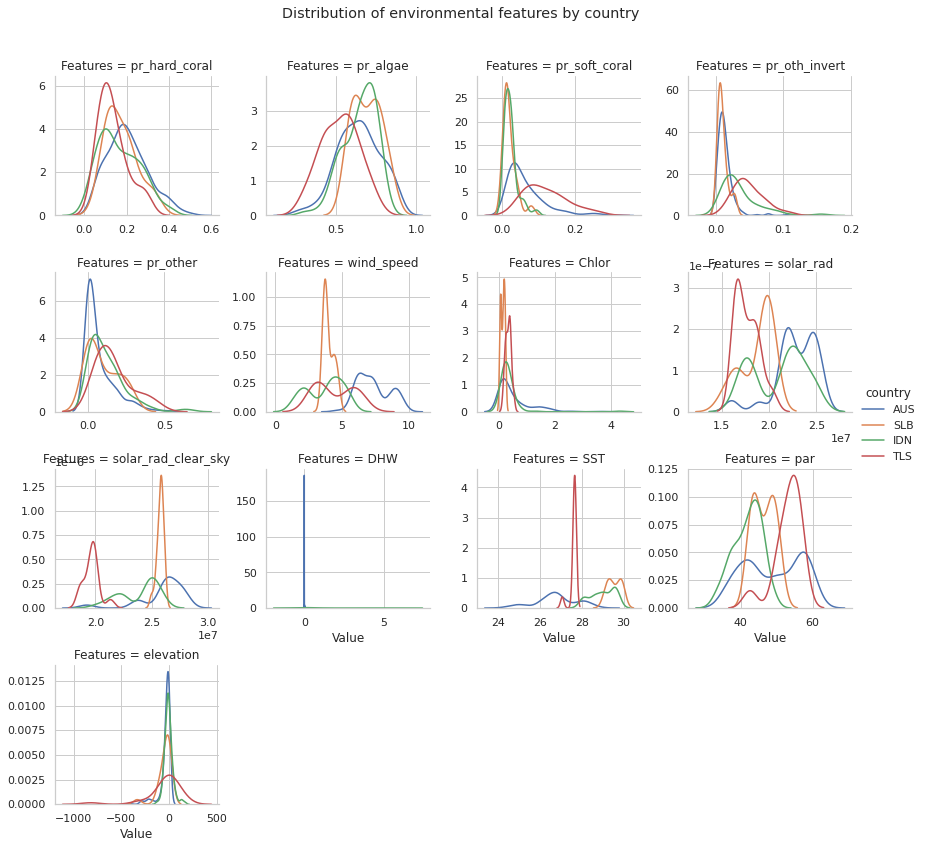

In [109]:
numeric_features= df_data_env.drop(columns = ['country', 'geometry','year'])
numeric_features = numeric_features.stack().reset_index().rename(columns = {"level_1":"Features",0:"Value"})
df_country =  pd.DataFrame(df_data_env["country"])
merged_num = pd.merge(df_country, numeric_features, left_index=True, right_on='level_0')
g = sns.FacetGrid(data =merged_num, col="Features",  hue = "country",col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "Value",  hist = False)
g.add_legend()
plt.subplots_adjust(top=0.9)
plt.suptitle("Distribution of environmental features by country")

Text(0.5, 0.98, 'Distribution of all features by Year')

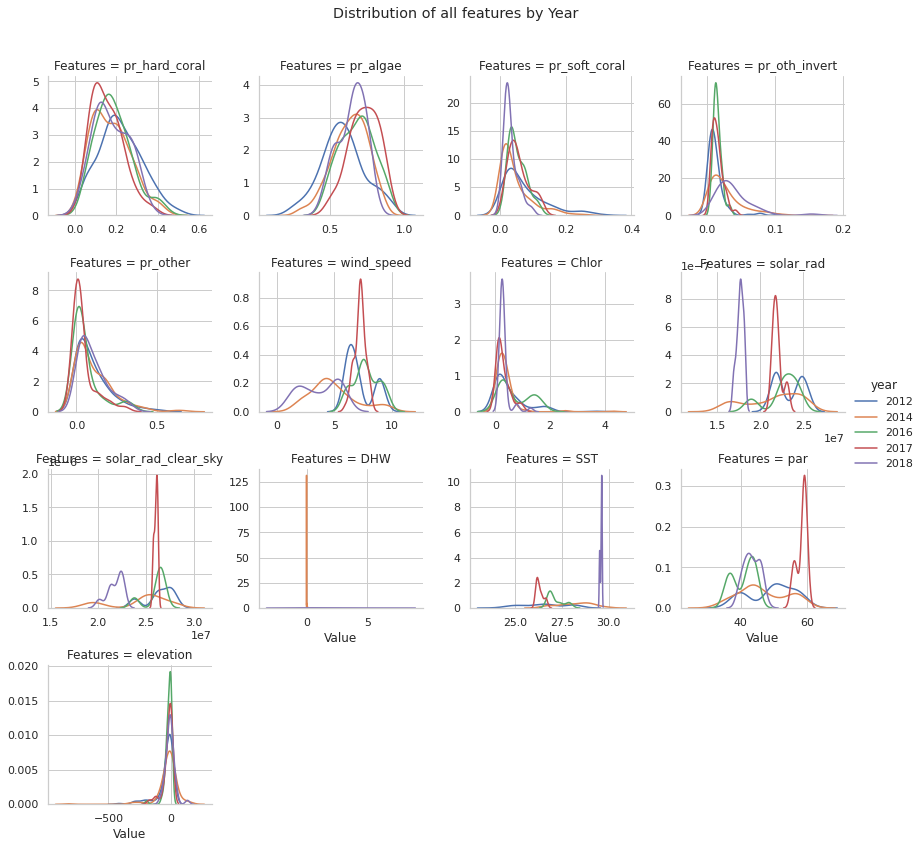

In [110]:
numeric_features= df_data_env.drop(columns = ['year','country', 'geometry'])
numeric_features = numeric_features.stack().reset_index().rename(columns = {"level_1":"Features",0:"Value"})
df_year=  pd.DataFrame(df_data["year"])
merged_num = pd.merge(df_year, numeric_features, left_index=True, right_on='level_0')
g = sns.FacetGrid(data =merged_num, col="Features",  hue = "year",col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "Value", hist = False)
g.add_legend()
plt.subplots_adjust(top=0.9)
plt.suptitle("Distribution of all features by Year")

df_data_env### Correlation Matrix


In [111]:
df_keep_env = []
df_keep_env_ext = []
df_keep_anth = []

In [112]:

def keep_interesting_corr(corr, df_keep, string):
    return df_keep.append(corr["pr_hard_coral"][1:].to_frame(string))


Text(0.5, 1.0, 'Correlation map for all data')

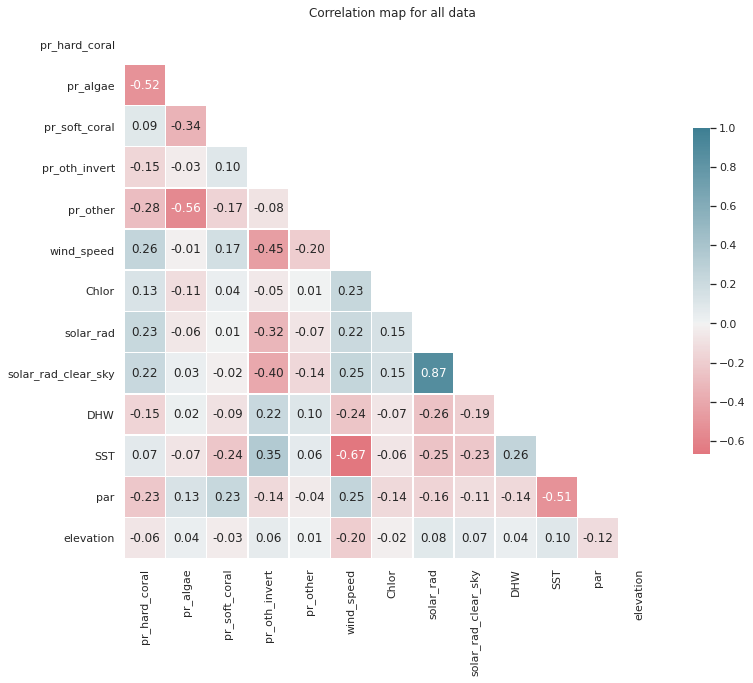

In [113]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_env.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr,df_keep_env, "All data (416)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
# plt.subplots_adjust(top=0.99)
plt.title("Correlation map for all data")

## Separated by year

In [114]:
df_data_env12 = df_data_env[df_data_env["year"] == 2012]
df_data_env14 = df_data_env[df_data_env["year"] == 2014]
df_data_env16 = df_data_env[df_data_env["year"] == 2016]
df_data_env17 = df_data_env[df_data_env["year"] == 2017]
df_data_env18 = df_data_env[df_data_env["year"] == 2018]


In [115]:
print(len(df_data_env12))
print(len(df_data_env14))
print(len(df_data_env16))
print(len(df_data_env17))
len(df_data_env18)

118
162
60
35


41

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2012 (only AUS)')

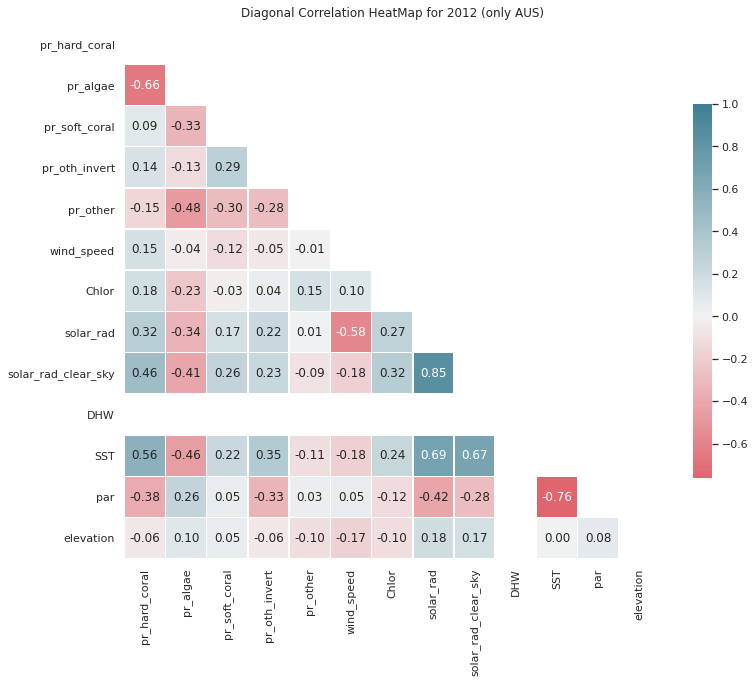

In [116]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_env12.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr,df_keep_env, "2012 (118)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2012 (only AUS)")

**Take-aways**
Hard corals have:
- Negative corr with algae (normal)
- Positive corr with solar rad and surface temperature (strange)
- Negative corr with PAR (normal)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2014 (all countries)')

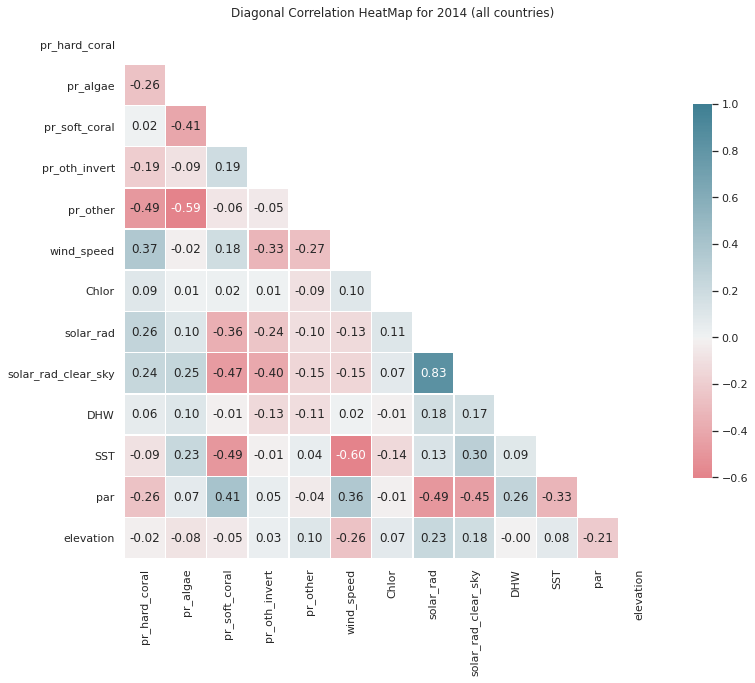

In [117]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_env14.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr,df_keep_env, "2014 (162)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2014 (all countries)")

**Take-aways**
- Positive corr with wind speed (normal)


Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2016 (only AUS)')

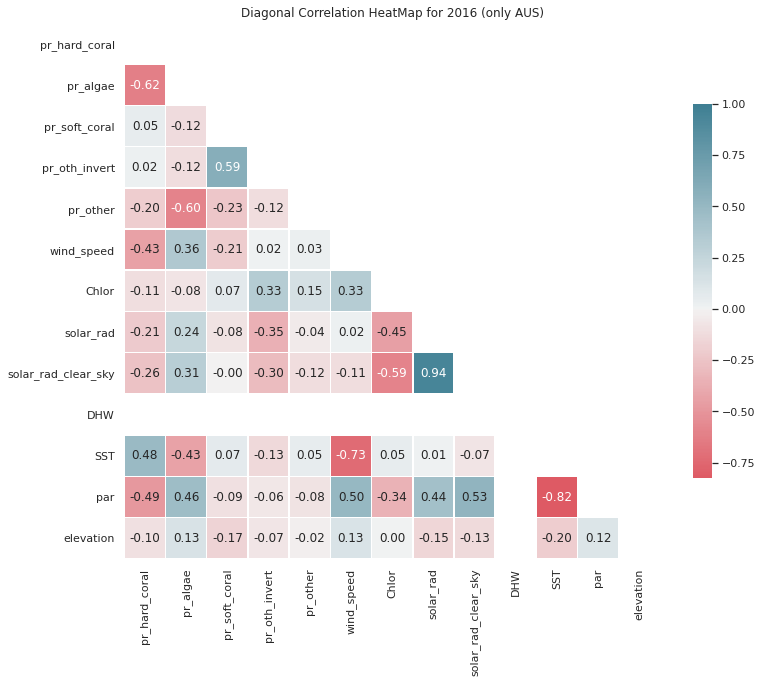

In [118]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_env16.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr,df_keep_env, "2016 (60)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2016 (only AUS)")

**Take-aways**
Hard corals have:
- Negative corr with wind speed (strange)
- Positive corr with SST (strange)
- Negative corr with PAR (normal)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2017 (only AUS)')

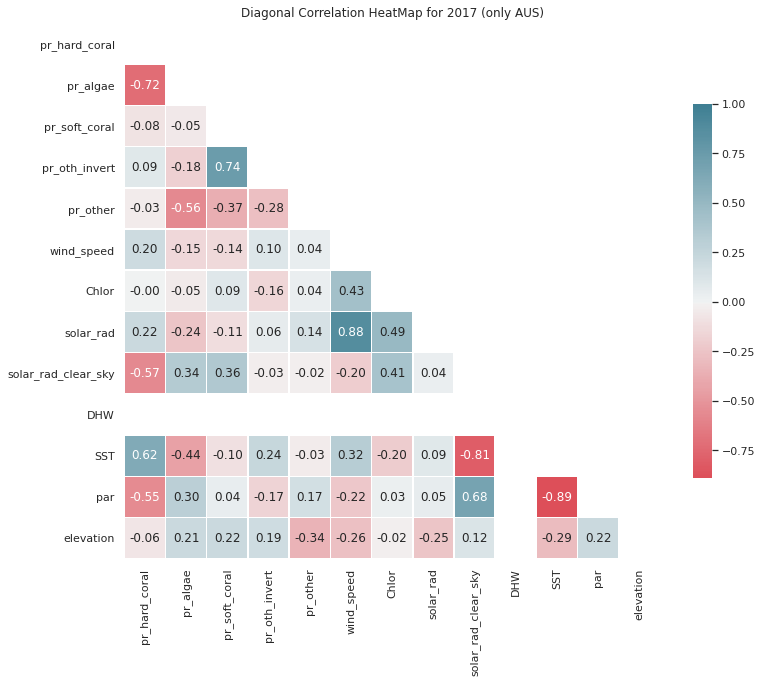

In [119]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_env17.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr,df_keep_env,"2017 (35)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2017 (only AUS)")

**Take-aways**
hard corals have:
- negative corr with solar rad (normal)
- positive corr with SST (strange)
- negative corr with PAR (normal)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2018 (only IDN)')

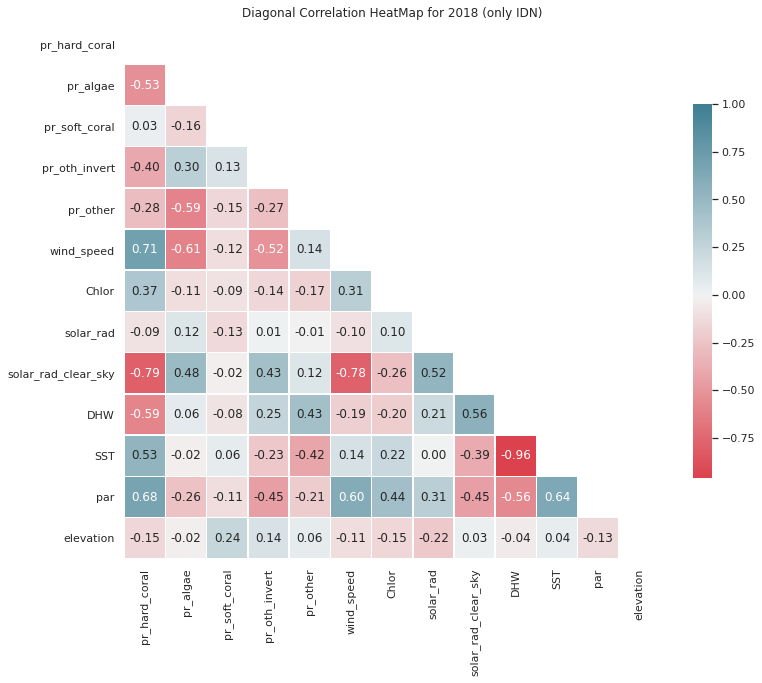

In [120]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_env18.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr,df_keep_env, "2018 (41)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2018 (only IDN)")

**Take-aways**
Hard corals:
- positive corr with wind speed (normal)
- negative corr with DHW/Solar (normal)
- Positive corr with SST/PAR (strange)

### Separated by Country

In [121]:
df_data_envAUS = df_data_env[df_data_env["country"] == "AUS"]
df_data_envIDN = df_data_env[df_data_env["country"] == "IDN"]
df_data_envTLS = df_data_env[df_data_env["country"] == "TLS"]
df_data_envSLB = df_data_env[df_data_env["country"] == "SLB"]

In [122]:
print(len(df_data_envAUS))
print(len(df_data_envIDN))
print(len(df_data_envTLS))
print(len(df_data_envSLB))


260
110
26
20


Text(0.5, 1.0, 'Diagonal Correlation HeatMap for Solomon')

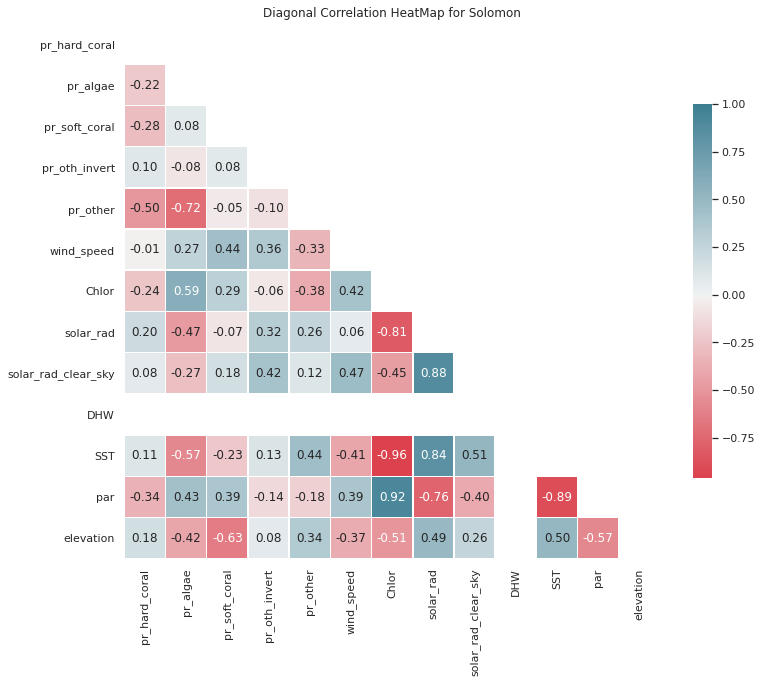

In [123]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_envSLB.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr,df_keep_env, "SLB (20)") 
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for Solomon")

**Take-aways**
Hard corals:
- Negative corr with PAR (normal)


Text(0.5, 1.0, 'Diagonal Correlation HeatMap for Timor Leste')

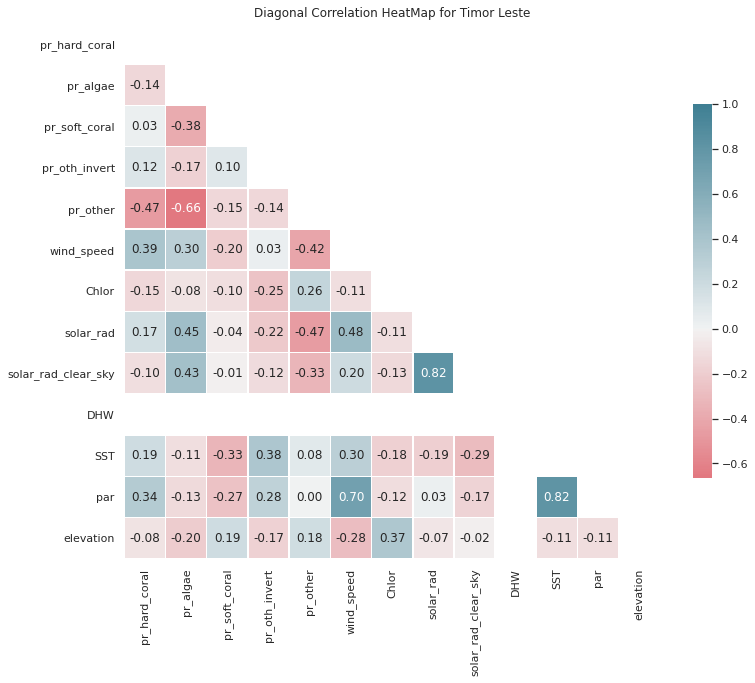

In [124]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_envTLS.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr,df_keep_env, "TLS (26)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for Timor Leste")

**Take-aways**

Hard corals have:
- Positive corr with wind speed (normal)
- Positive corr with PAR (strange)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for Australia')

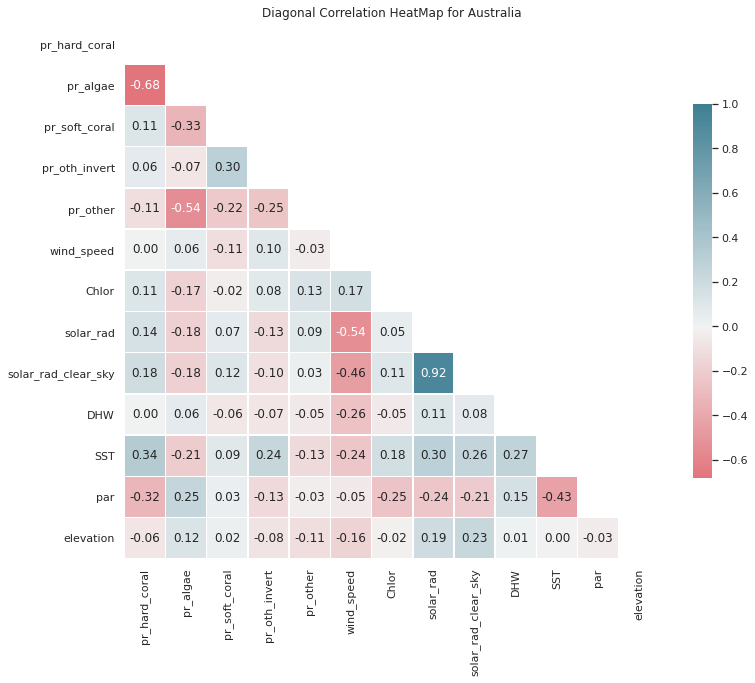

In [125]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_envAUS.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr,df_keep_env, "AUS (260)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for Australia")

**Take-aways**

Hard corals:
- Positive corr with SST (strange)
- Negative corr with PAR (normal)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for Indonesia')

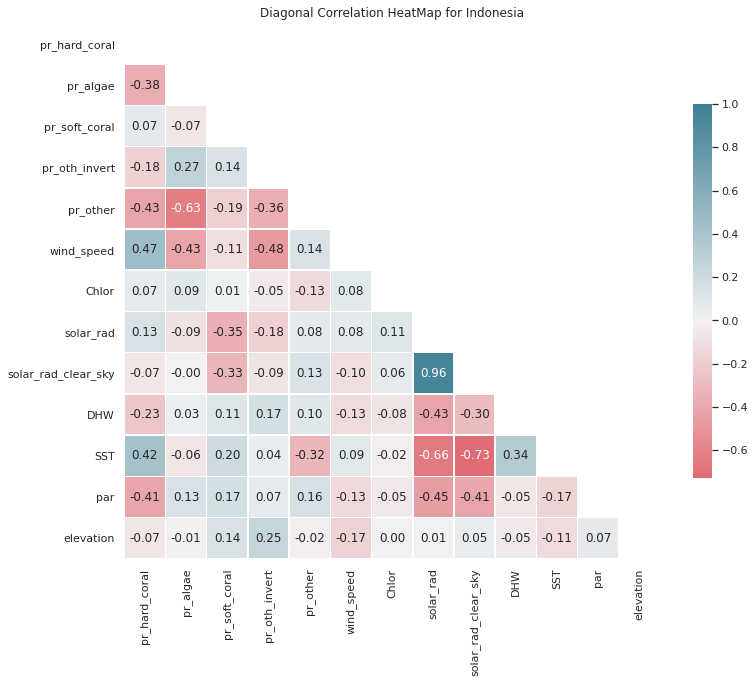

In [126]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_envIDN.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr,df_keep_env, "IDN (110)") 
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for Indonesia")

**Take-aways**

Hard corals have:
- Positive corr with wind speed

In [127]:
frame_corr_env = pd.concat(df_keep_env, axis = 1)

In [128]:
classes = frame_corr_env.columns

In [129]:
strs = ["pr_hard" for x in range(len(frame_corr_env.columns))]

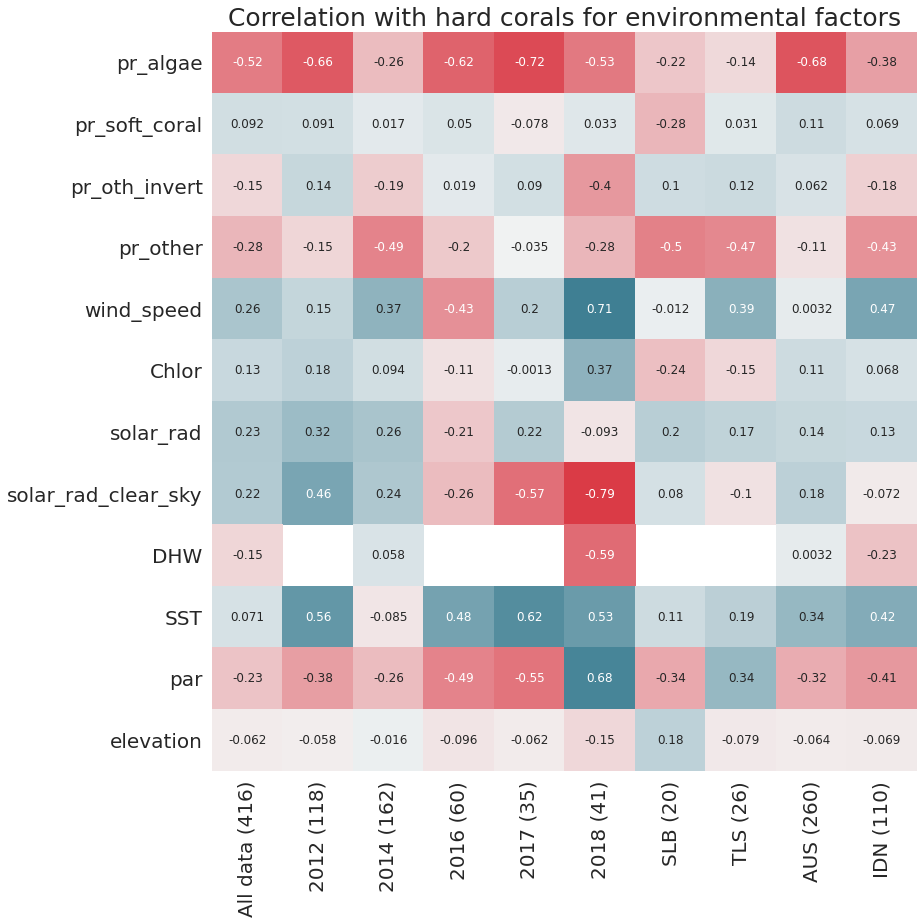

In [130]:
plt.figure(figsize=(13,13))
yticks = frame_corr_env.index
keptticks = yticks[::int(len(yticks)/10)]
yticks = ['' for y in yticks]
yticks[::int(len(yticks)/10)] = keptticks

xticks = frame_corr_env.columns
#xticks = strs
keptticks = xticks[::int(len(xticks)/10)]
xticks = ['' for y in xticks]
xticks[::int(len(xticks)/10)] = keptticks
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(frame_corr_env,cmap = cmap, linewidth=0,yticklabels=yticks,xticklabels=xticks,annot=True, cbar = False)

# This sets the yticks "upright" with 0, as opposed to sideways with 90.
plt.yticks(rotation=0, fontsize=20) 
plt.xticks(rotation=90, fontsize=20) 
plt.title("Correlation with hard corals for environmental factors", fontsize=25)
plt.tight_layout()
plt.show()



## Anthropological data

In [131]:
col_anth = ['pr_hard_coral', 'pr_algae','pr_soft_coral', 'pr_oth_invert', 'pr_other', 'country','geometry', 'closest_port', 'year', 'distance_urban',
       'dist_marine_protection', 'Population', 'Population_growth',
        'dist_agr_AUS', 'mine_area_per_call',
       'distance_to_mine_area', 'mine_area_per_cell', 'nigh_avg_2012',
       'nigh_avg_2013', 'nigh_avg_2014', 'nigh_avg_2015', 'nigh_avg_2016',
       'nigh_avg_2017', 'nigh_avg_2018', 'fish_hours_2012', 'fish_hours_2014',
       'fish_hours_2017', 'fish_hours_2016', 'distance_agr_land']
df_data_anth = df_data[col_anth]

### Distribution plots for numerical values depending on country

Text(0.5, 0.98, 'Distribution of anthropological features by country')

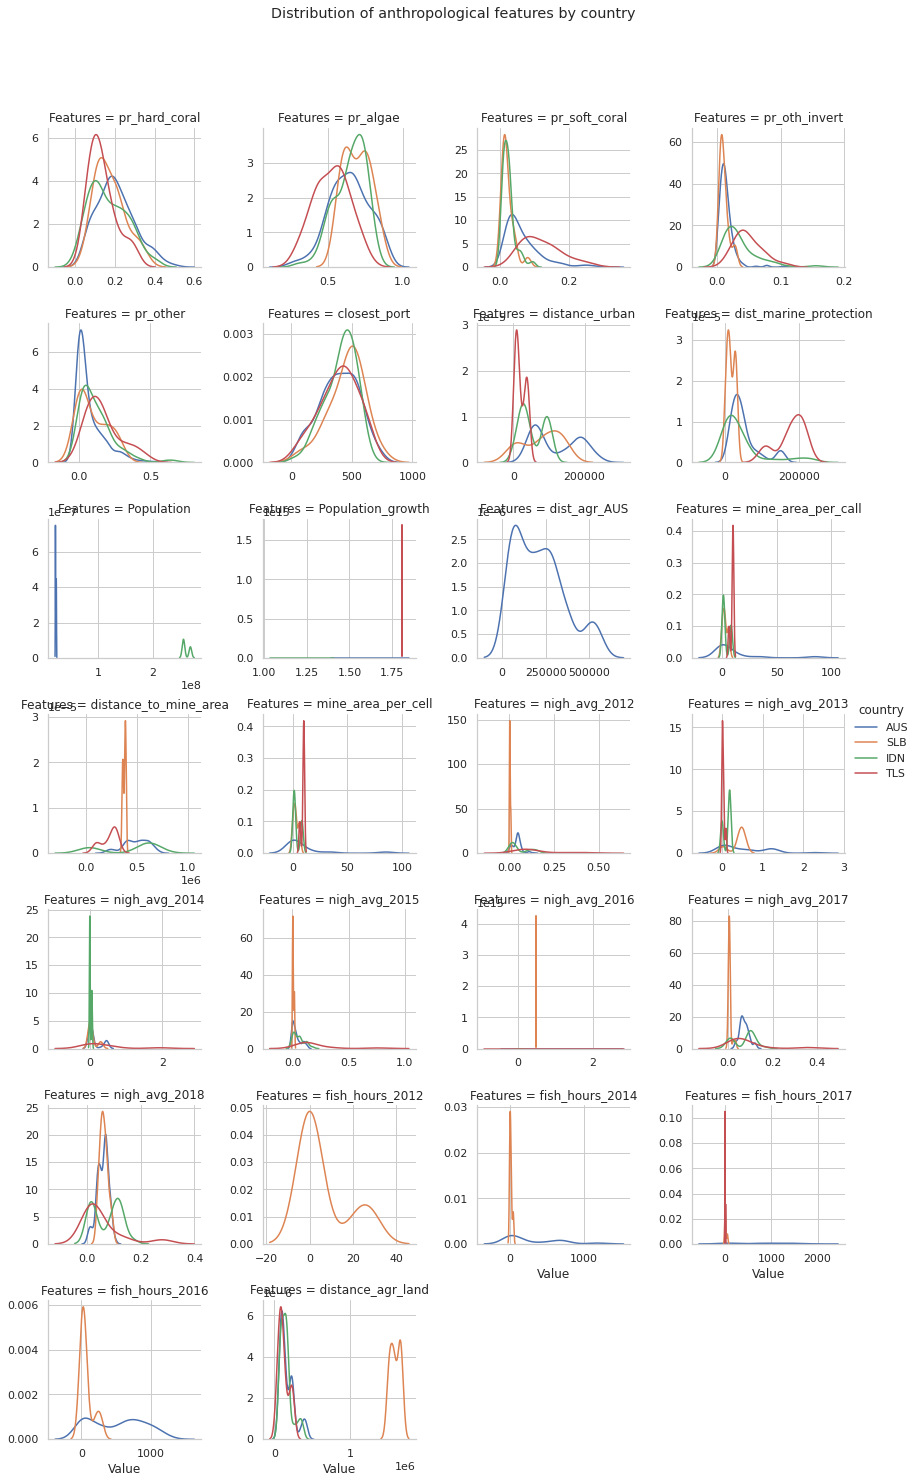

In [132]:
numeric_features= df_data_anth.drop(columns = ['country', 'geometry','year'])
numeric_features = numeric_features.stack().reset_index().rename(columns = {"level_1":"Features",0:"Value"})
df_country =  pd.DataFrame(df_data_anth["country"])
merged_num = pd.merge(df_country, numeric_features, left_index=True, right_on='level_0')
g = sns.FacetGrid(data =merged_num, col="Features",  hue = "country",col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "Value",  hist = False)
g.add_legend()
plt.subplots_adjust(top=0.9)
plt.suptitle("Distribution of anthropological features by country")

### Correlation Matrix


In [133]:
df_keep_anth = []

Text(0.5, 1.0, 'Correlation map for all data')

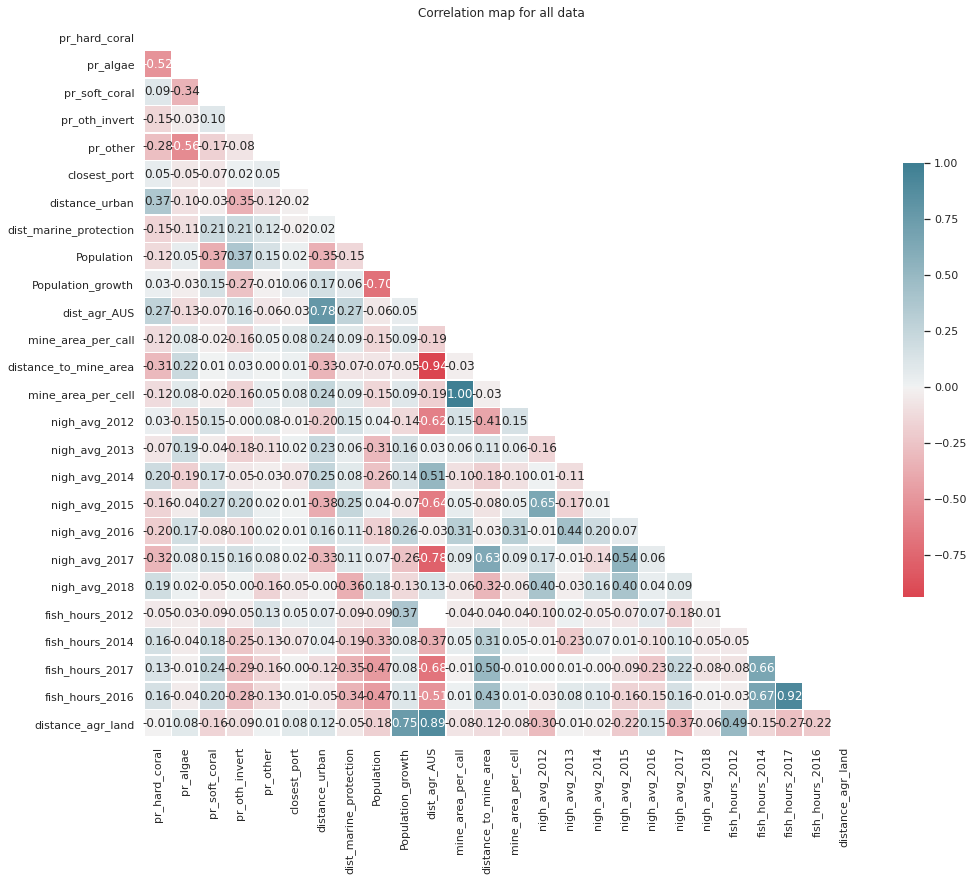

In [134]:
f, ax = plt.subplots(figsize=(16, 16))
corr = df_data_anth.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr, df_keep_anth, "All data (416)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
# plt.subplots_adjust(top=0.99)
plt.title("Correlation map for all data")

## Separated by year

In [135]:
df_data_anth12 = df_data_anth[df_data_anth["year"] == 2012]
df_data_anth14 = df_data_anth[df_data_anth["year"] == 2014]
df_data_anth16 = df_data_anth[df_data_anth["year"] == 2016]
df_data_anth17 = df_data_anth[df_data_anth["year"] == 2017]
df_data_anth18 = df_data_anth[df_data_anth["year"] == 2018]


Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2012 (only AUS)')

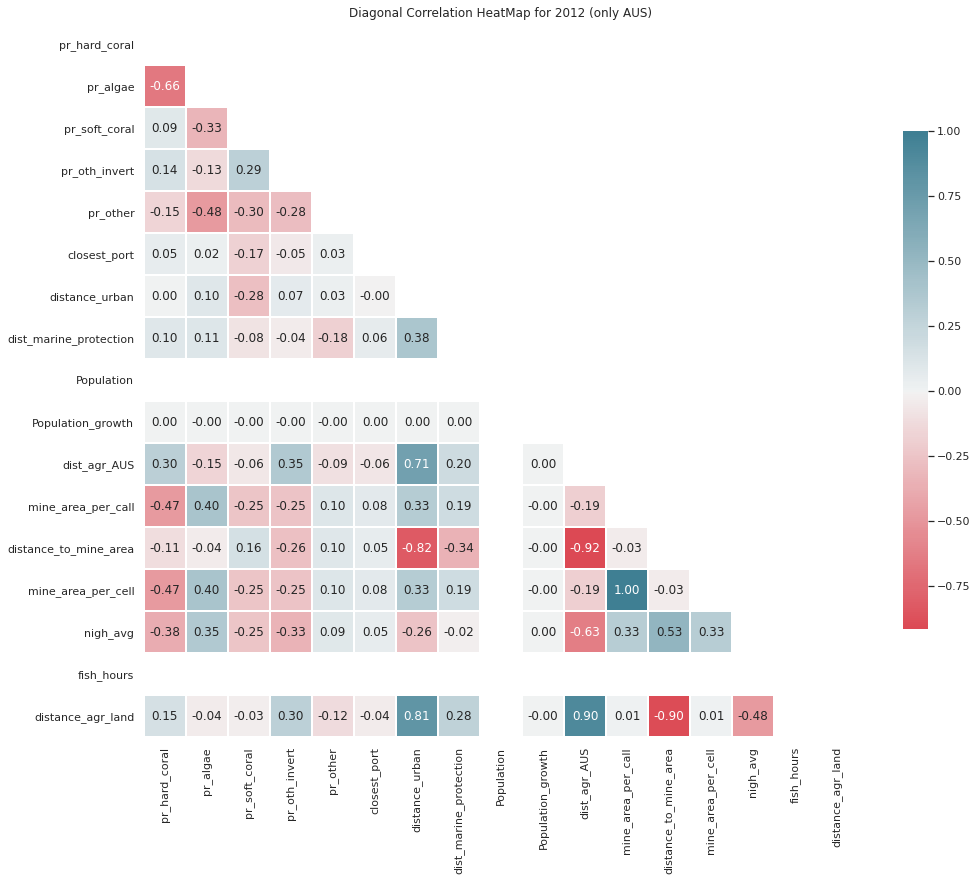

In [136]:
f, ax = plt.subplots(figsize=(16, 16))
corr = df_data_anth12.drop(columns = ['year','country', 'geometry', 'nigh_avg_2013', 'nigh_avg_2014', 'nigh_avg_2015', 'nigh_avg_2016',
       'nigh_avg_2017', 'nigh_avg_2018', 'fish_hours_2014',
       'fish_hours_2017', 'fish_hours_2016']).corr()
corr.rename(index = {"nigh_avg_2012" : "nigh_avg","fish_hours_2012" : "fish_hours"}, columns = {"fish_hours_2012" : "fish_hours","nigh_avg_2012" : "nigh_avg"}, inplace = True)
keep_interesting_corr(corr, df_keep_anth, "2012 (118)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2012 (only AUS)")

**Take-aways**
Hard corals have:
- Negative corr with algae (normal)
- Positive corr with solar rad and surface temperature (strange)
- Negative corr with PAR (normal)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2014 (all countries)')

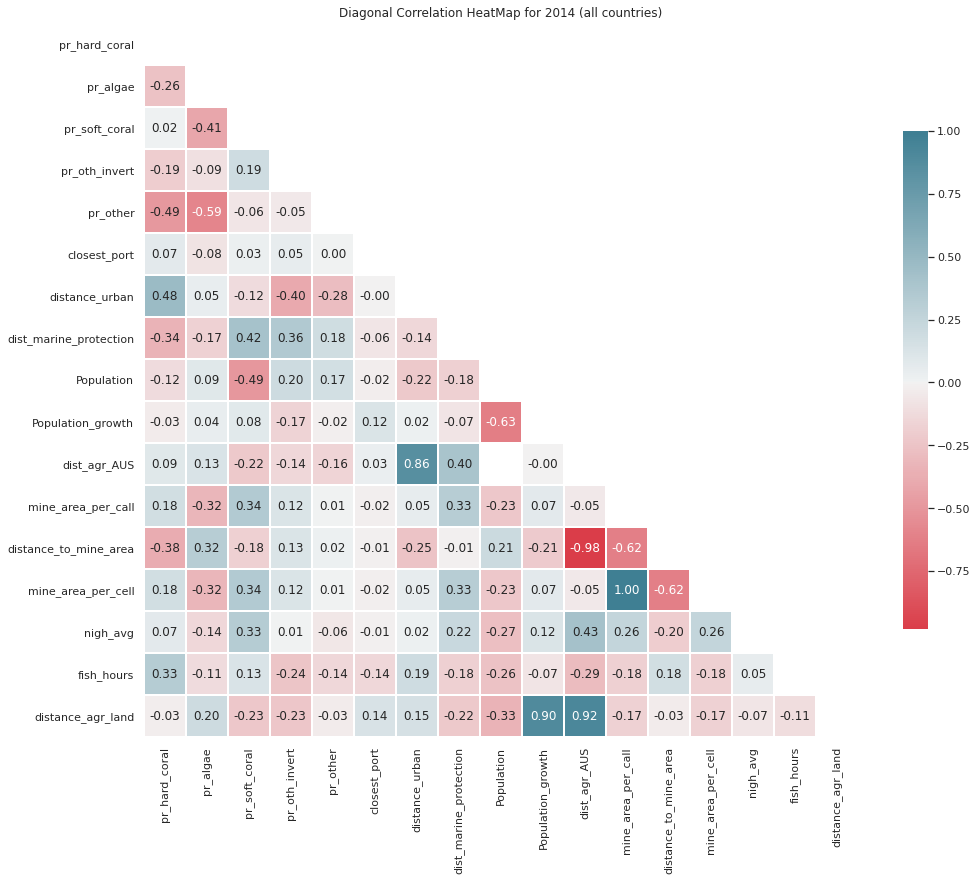

In [137]:
f, ax = plt.subplots(figsize=(16, 16))

corr = df_data_anth14.drop(columns = ['year','country', 'geometry', 'nigh_avg_2013', 'nigh_avg_2012', 'nigh_avg_2015', 'nigh_avg_2016',
       'nigh_avg_2017', 'nigh_avg_2018', 'fish_hours_2012',
       'fish_hours_2017', 'fish_hours_2016']).corr()
corr.rename(index = {"nigh_avg_2014" : "nigh_avg","fish_hours_2014" : "fish_hours"}, columns = {"fish_hours_2014" : "fish_hours","nigh_avg_2014" : "nigh_avg"}, inplace = True)
keep_interesting_corr(corr, df_keep_anth, "2014 (162)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2014 (all countries)")

**Take-aways**
- Positive corr with wind speed (normal)


Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2016 (only AUS)')

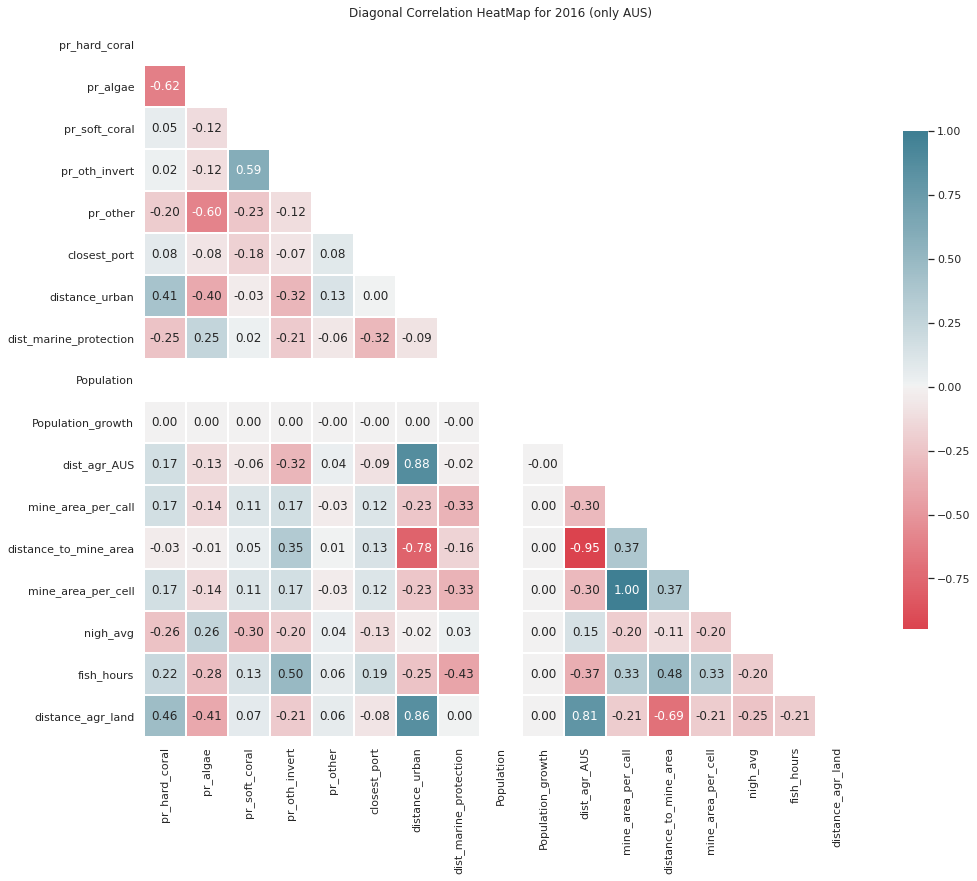

In [138]:
f, ax = plt.subplots(figsize=(16, 16))

corr = df_data_anth16.drop(columns = ['year','country', 'geometry', 'nigh_avg_2013', 'nigh_avg_2014', 'nigh_avg_2015', 'nigh_avg_2012',
       'nigh_avg_2017', 'nigh_avg_2018', 'fish_hours_2014',
       'fish_hours_2017', 'fish_hours_2012']).corr()
corr.rename(index = {"nigh_avg_2016" : "nigh_avg","fish_hours_2016" : "fish_hours"}, columns = {"fish_hours_2016" : "fish_hours","nigh_avg_2016" : "nigh_avg"}, inplace = True)
keep_interesting_corr(corr, df_keep_anth, "2016 (60)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2016 (only AUS)")

**Take-aways**
Hard corals have:
- Negative corr with wind speed (strange)
- Positive corr with SST (strange)
- Negative corr with PAR (normal)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2017 (only AUS)')

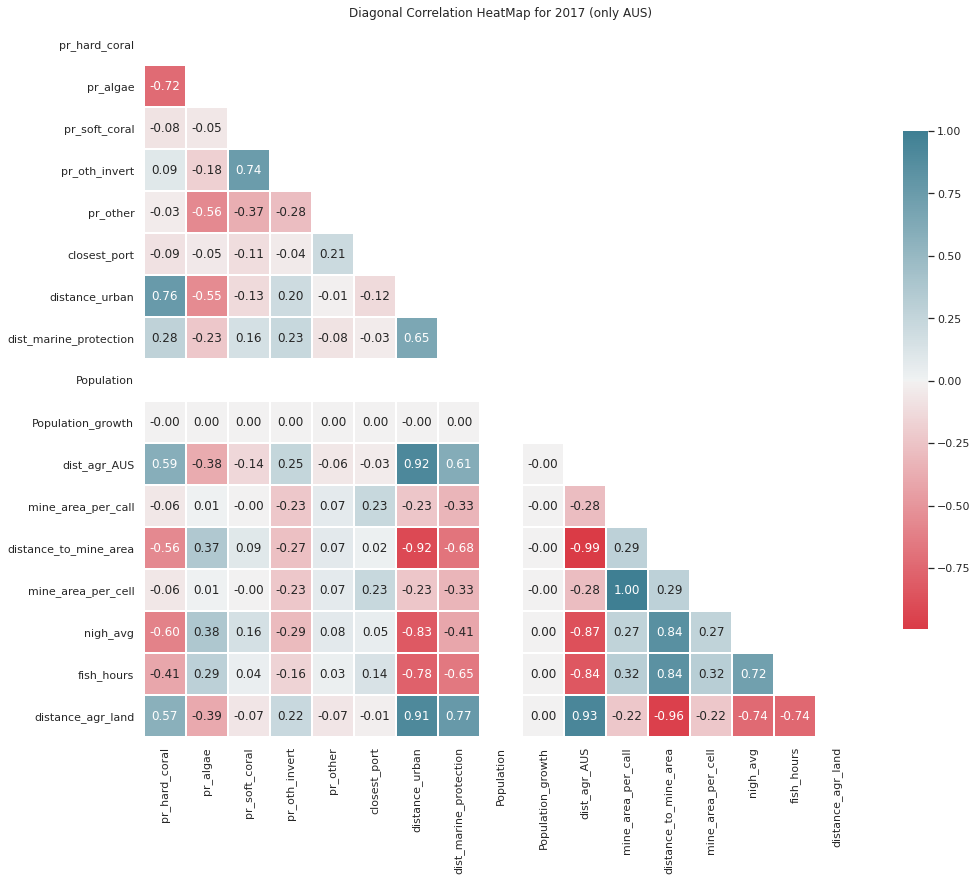

In [139]:
f, ax = plt.subplots(figsize=(16, 16))

corr = df_data_anth17.drop(columns = ['year','country', 'geometry', 'nigh_avg_2013', 'nigh_avg_2014', 'nigh_avg_2015', 'nigh_avg_2016',
       'nigh_avg_2012', 'nigh_avg_2018', 'fish_hours_2014',
       'fish_hours_2012', 'fish_hours_2016']).corr()
corr.rename(index = {"nigh_avg_2017" : "nigh_avg","fish_hours_2017" : "fish_hours"}, columns = {"fish_hours_2017" : "fish_hours","nigh_avg_2017" : "nigh_avg"}, inplace = True)
keep_interesting_corr(corr, df_keep_anth, "2017 (35)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2017 (only AUS)")

**Take-aways**
hard corals have:
- negative corr with solar rad (normal)
- positive corr with SST (strange)
- negative corr with PAR (normal)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2018 (only IDN)')

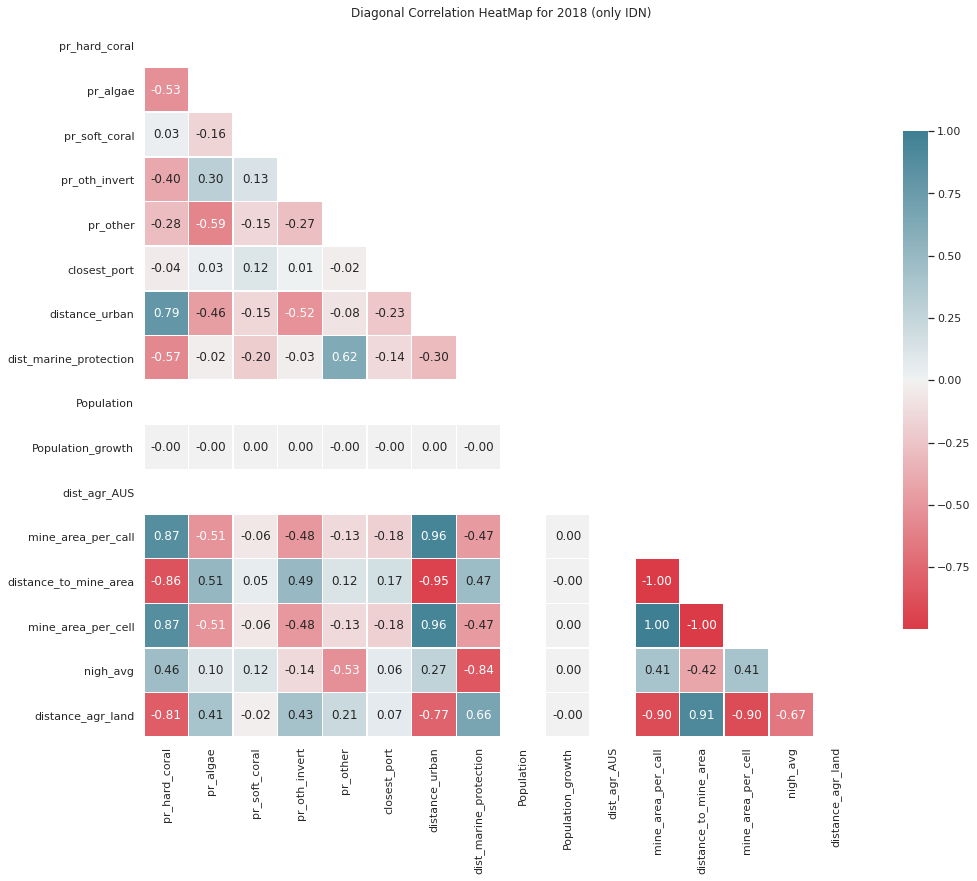

In [140]:
f, ax = plt.subplots(figsize=(16, 16))

corr = df_data_anth18.drop(columns = ['year','country', 'geometry', 'nigh_avg_2013', 'nigh_avg_2014', 'nigh_avg_2015', 'nigh_avg_2016',
       'nigh_avg_2017', 'nigh_avg_2012', 'fish_hours_2014',
       'fish_hours_2017', 'fish_hours_2016','fish_hours_2012']).corr()
corr.rename(index = {"nigh_avg_2018" : "nigh_avg"}, columns = {"nigh_avg_2018" : "nigh_avg"}, inplace = True) 
keep_interesting_corr(corr, df_keep_anth, "2018 (41)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2018 (only IDN)")

**Take-aways**
Hard corals:
- positive corr with wind speed (normal)
- negative corr with DHW/Solar (normal)
- Positive corr with SST/PAR (strange)

### Separated by Country

In [141]:
df_data_anthAUS = df_data_anth[df_data_anth["country"] == "AUS"]
df_data_anthIDN = df_data_anth[df_data_anth["country"] == "IDN"]
df_data_anthTLS = df_data_anth[df_data_anth["country"] == "TLS"]
df_data_anhtSLB = df_data_anth[df_data_anth["country"] == "SLB"]


print(len(df_data_anthAUS))
print(len(df_data_anthIDN))
print(len(df_data_anthTLS))
print(len(df_data_anhtSLB))

260
110
26
20


Text(0.5, 1.0, 'Diagonal Correlation HeatMap for Solomon')

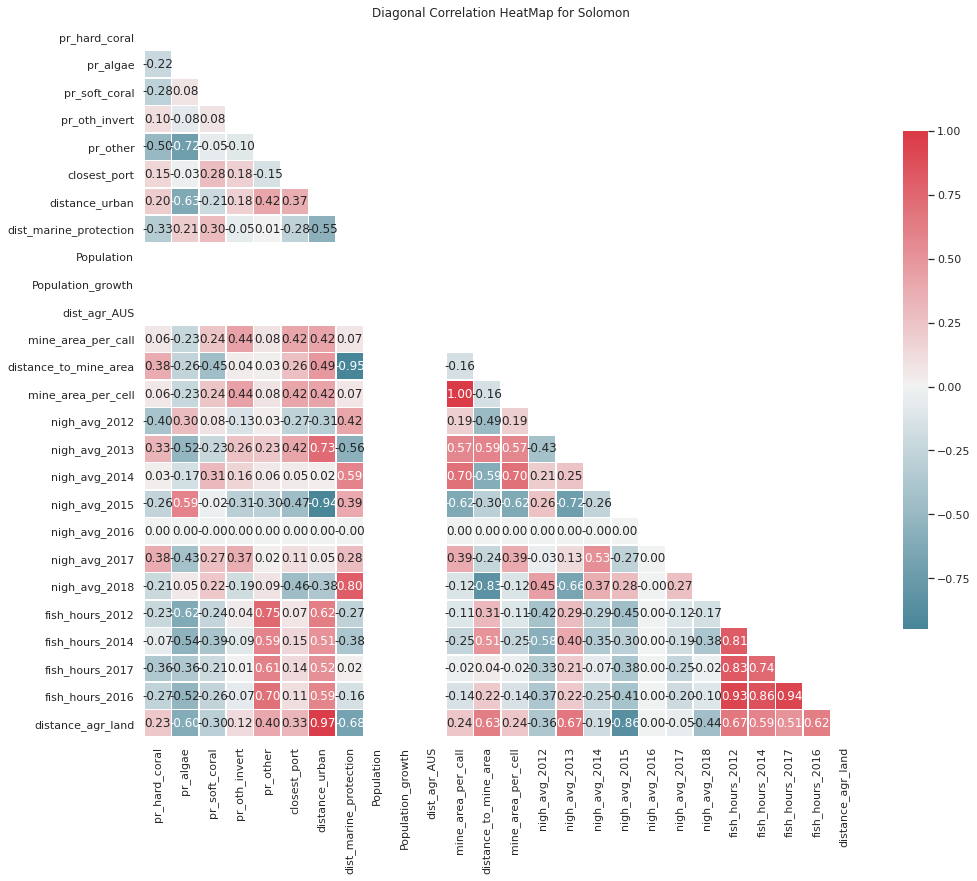

In [142]:
f, ax = plt.subplots(figsize=(16, 16))

corr = df_data_anhtSLB.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr, df_keep_anth, "SLB (20)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(220, 10, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for Solomon")

**Take-aways**
Hard corals:
- Negative corr with PAR (normal)


Text(0.5, 1.0, 'Diagonal Correlation HeatMap for Timor Leste')

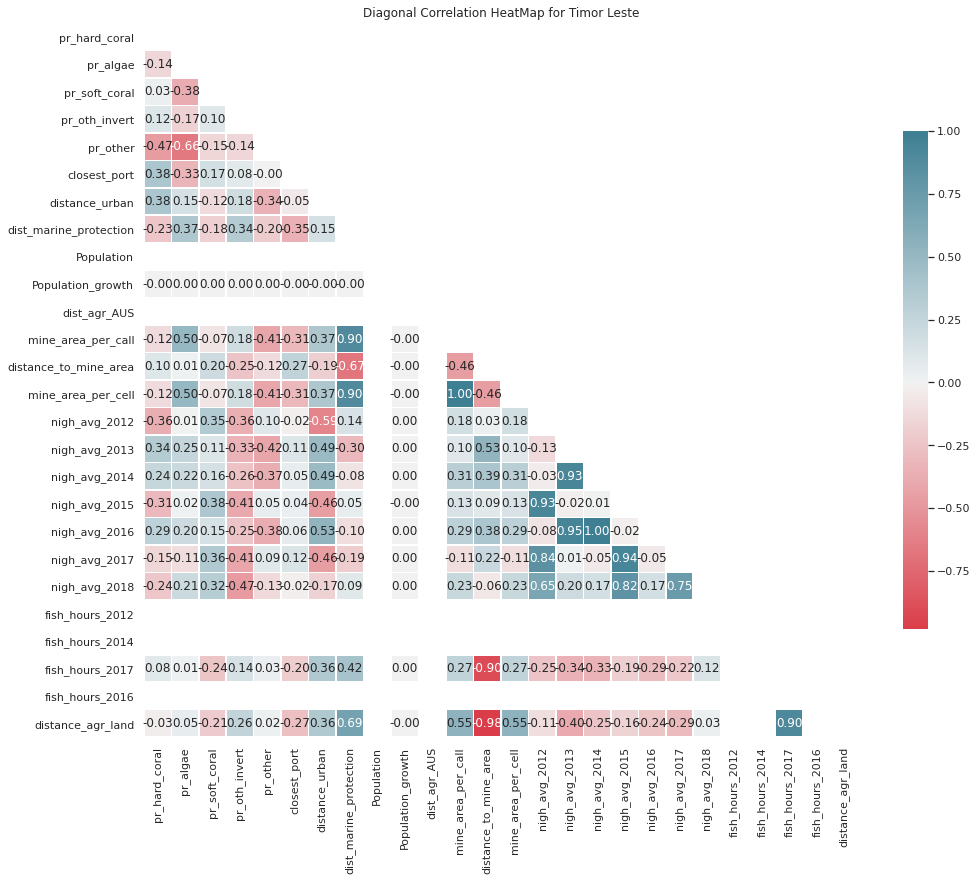

In [143]:
f, ax = plt.subplots(figsize=(16, 16))
corr = df_data_anthTLS.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr, df_keep_anth, "TLS (26)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for Timor Leste")

**Take-aways**

Hard corals have:
- Positive corr with wind speed (normal)
- Positive corr with PAR (strange)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for Australia')

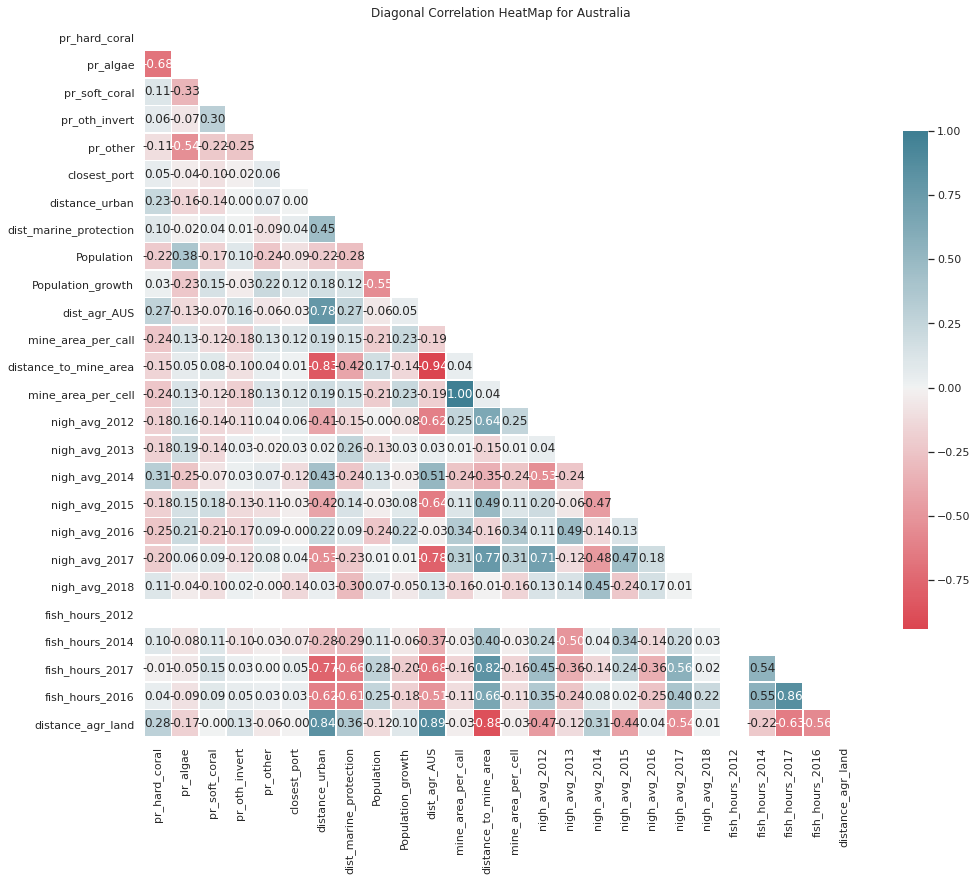

In [144]:
f, ax = plt.subplots(figsize=(16, 16))
corr = df_data_anthAUS.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr, df_keep_anth, "AUS (260)") 
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for Australia")

**Take-aways**

Hard corals:
- Positive corr with SST (strange)
- Negative corr with PAR (normal)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for Indonesia')

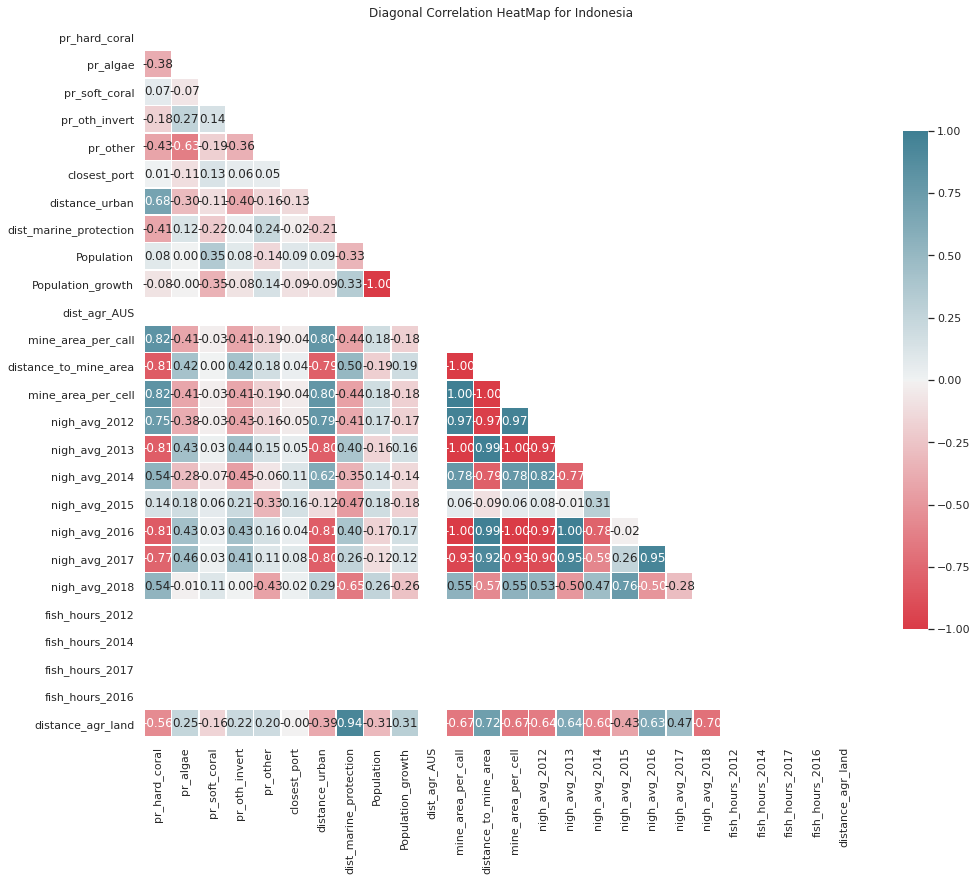

In [145]:
f, ax = plt.subplots(figsize=(16, 16))
corr = df_data_anthIDN.drop(columns = ['year','country', 'geometry']).corr()
keep_interesting_corr(corr, df_keep_anth, "IDN (110)") 
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for Indonesia")

**Take-aways**

Hard corals have:
- Positive corr with wind speed

In [149]:
corr_frame_anth = pd.concat(df_keep_anth, axis = 1)

In [152]:
corr_frame_anth = corr_frame_anth.iloc[4:].drop(index = "mine_area_per_call")

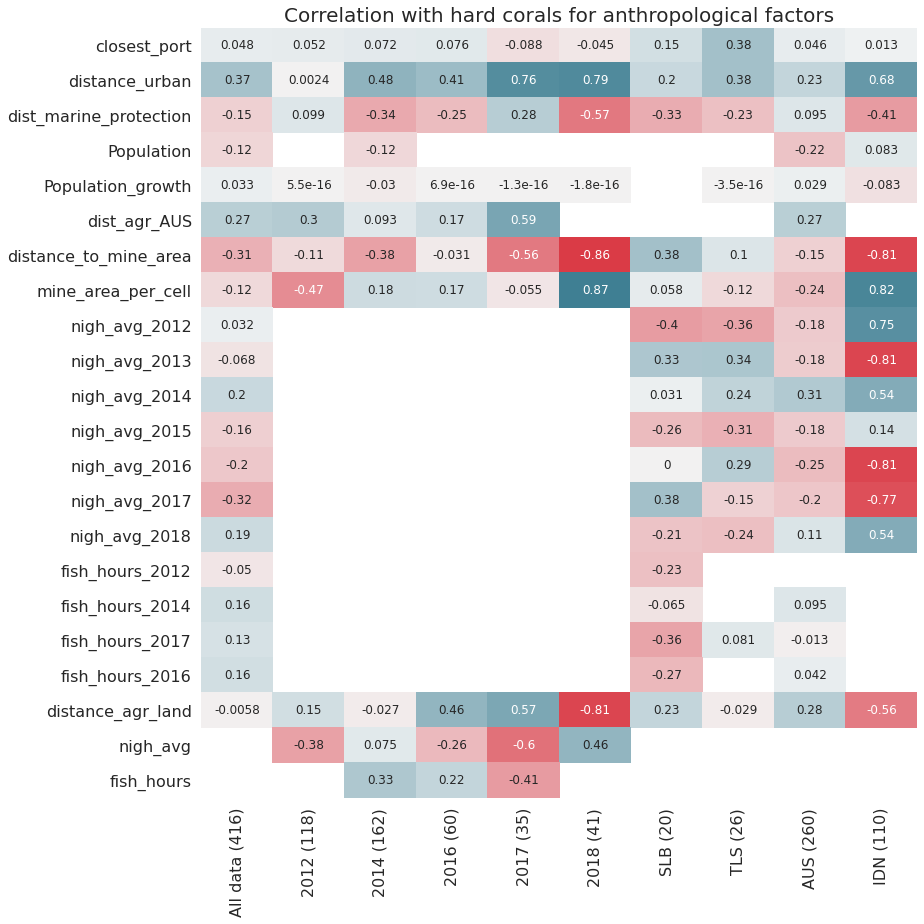

In [153]:
plt.figure(figsize=(13,13))
yticks = corr_frame_anth.index
#keptticks = yticks[::int(len(yticks)/10)]
#yticks = ['' for y in yticks]
#yticks[::int(len(yticks)/10)] = keptticks

xticks = corr_frame_anth.columns
#xticks = strs
keptticks = xticks[::int(len(xticks)/10)]
xticks = ['' for y in xticks]
xticks[::int(len(xticks)/10)] = keptticks
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(corr_frame_anth,cmap = cmap, linewidth=0,yticklabels=yticks,xticklabels=xticks,annot=True, cbar = False)

# This sets the yticks "upright" with 0, as opposed to sideways with 90.
plt.yticks(rotation=0, fontsize = 16) 
plt.xticks(rotation=90, fontsize = 16) 
plt.title("Correlation with hard corals for anthropological factors", fontsize = 20)
plt.tight_layout()
plt.show()



### Extended Data

In [70]:
df_keep_env_ext = []

Text(0.5, 1.0, 'Correlation map for all data for anthropological factors')

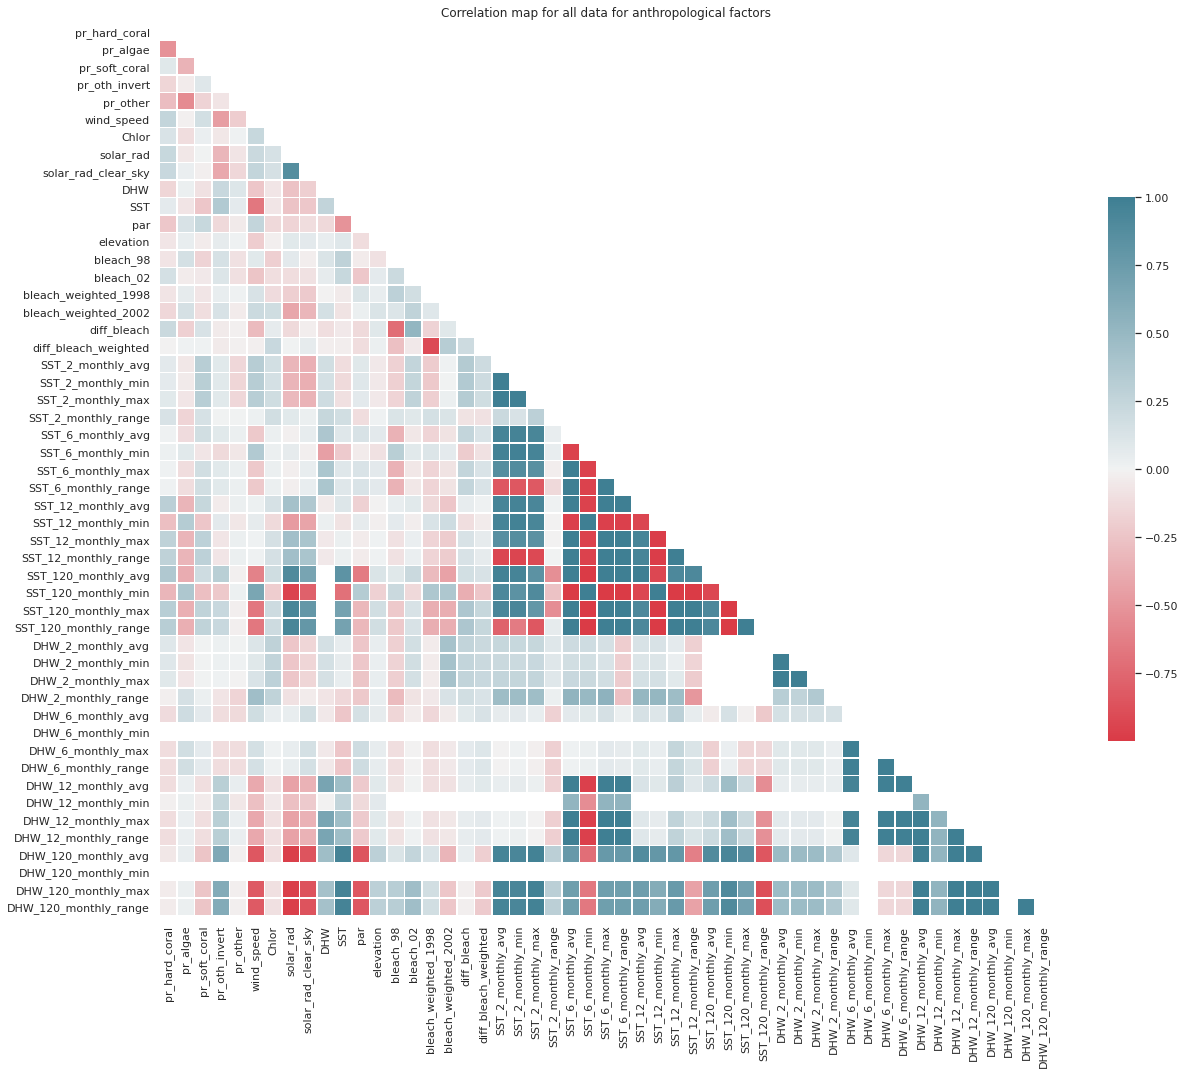

In [71]:
f, ax = plt.subplots(figsize=(20, 20))
corr = df_data_env_ext.drop(columns = ['year','country', 'geometry', 'clear_rad_solar_2_monthly_avg',
       'clear_rad_solar_2_monthly_min', 'clear_rad_solar_2_monthly_max',
       'clear_rad_solar_2_monthly_range', 'clear_rad_solar_6_monthly_avg',
       'clear_rad_solar_6_monthly_min', 'clear_rad_solar_6_monthly_max',
       'clear_rad_solar_6_monthly_range', 'clear_rad_solar_12_monthly_avg',
       'clear_rad_solar_12_monthly_min', 'clear_rad_solar_12_monthly_max',
       'clear_rad_solar_12_monthly_range', 'wind_2_monthly_avg',
       'wind_2_monthly_min', 'wind_2_monthly_max', 'wind_2_monthly_range',
       'wind_6_monthly_avg', 'wind_6_monthly_min', 'wind_6_monthly_max',
       'wind_6_monthly_range', 'wind_12_monthly_avg', 'wind_12_monthly_min',
       'wind_12_monthly_max', 'wind_12_monthly_range', 'wind_120_monthly_avg',
       'wind_120_monthly_min', 'wind_120_monthly_max',
       'wind_120_monthly_range', 'solar_2_monthly_avg', 'solar_2_monthly_min',
       'solar_2_monthly_max', 'solar_2_monthly_range', 'solar_6_monthly_avg',
       'solar_6_monthly_min', 'solar_6_monthly_max', 'solar_6_monthly_range',
       'solar_12_monthly_avg', 'solar_12_monthly_min', 'solar_12_monthly_max',
       'solar_12_monthly_range']).corr()
keep_interesting_corr(corr,df_keep_env_ext, "All data (416)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
# plt.subplots_adjust(top=0.99)
plt.title("Correlation map for all data for anthropological factors")

## Separated by year

In [72]:
df_data_env_ext12 = df_data_env_ext[df_data_env_ext["year"] == 2012]
df_data_env_ext14 = df_data_env_ext[df_data_env_ext["year"] == 2014]
df_data_env_ext16 = df_data_env_ext[df_data_env_ext["year"] == 2016]
df_data_env_ext17 = df_data_env_ext[df_data_env_ext["year"] == 2017]
df_data_env_ext18 = df_data_env_ext[df_data_env_ext["year"] == 2018]


Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2012 (only AUS)')

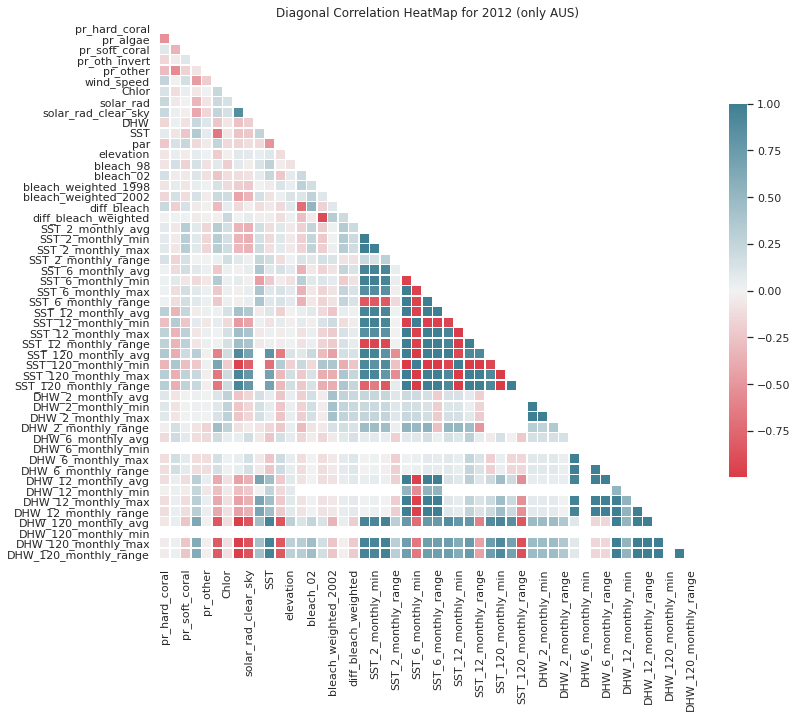

In [73]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_env_ext.drop(columns = ['year','country', 'geometry', 'clear_rad_solar_2_monthly_avg',
       'clear_rad_solar_2_monthly_min', 'clear_rad_solar_2_monthly_max',
       'clear_rad_solar_2_monthly_range', 'clear_rad_solar_6_monthly_avg',
       'clear_rad_solar_6_monthly_min', 'clear_rad_solar_6_monthly_max',
       'clear_rad_solar_6_monthly_range', 'clear_rad_solar_12_monthly_avg',
       'clear_rad_solar_12_monthly_min', 'clear_rad_solar_12_monthly_max',
       'clear_rad_solar_12_monthly_range', 'wind_2_monthly_avg',
       'wind_2_monthly_min', 'wind_2_monthly_max', 'wind_2_monthly_range',
       'wind_6_monthly_avg', 'wind_6_monthly_min', 'wind_6_monthly_max',
       'wind_6_monthly_range', 'wind_12_monthly_avg', 'wind_12_monthly_min',
       'wind_12_monthly_max', 'wind_12_monthly_range', 'wind_120_monthly_avg',
       'wind_120_monthly_min', 'wind_120_monthly_max',
       'wind_120_monthly_range', 'solar_2_monthly_avg', 'solar_2_monthly_min',
       'solar_2_monthly_max', 'solar_2_monthly_range', 'solar_6_monthly_avg',
       'solar_6_monthly_min', 'solar_6_monthly_max', 'solar_6_monthly_range',
       'solar_12_monthly_avg', 'solar_12_monthly_min', 'solar_12_monthly_max',
       'solar_12_monthly_range']).corr()
keep_interesting_corr(corr,df_keep_env_ext, "2012 (118)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2012 (only AUS)")

df_data_env14**Take-aways**
Hard corals have:
- Negative corr with algae (normal)
- Positive corr with solar rad and surface temperature (strange)
- Negative corr with PAR (normal)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2014 (all countries)')

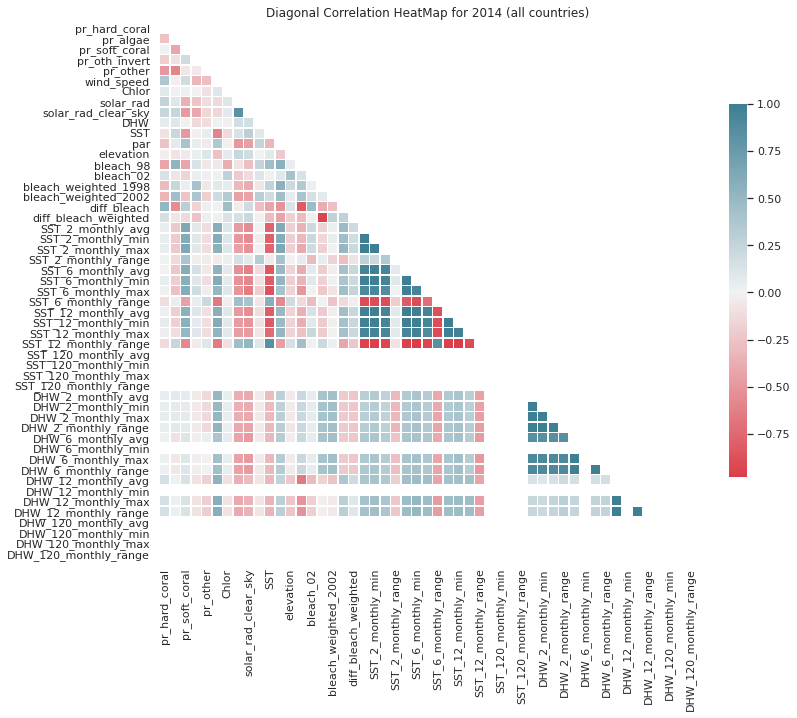

In [74]:
f, ax = plt.subplots(figsize=(12, 12))

corr = df_data_env_ext14.drop(columns = ['year','country', 'geometry', 'clear_rad_solar_2_monthly_avg',
       'clear_rad_solar_2_monthly_min', 'clear_rad_solar_2_monthly_max',
       'clear_rad_solar_2_monthly_range', 'clear_rad_solar_6_monthly_avg',
       'clear_rad_solar_6_monthly_min', 'clear_rad_solar_6_monthly_max',
       'clear_rad_solar_6_monthly_range', 'clear_rad_solar_12_monthly_avg',
       'clear_rad_solar_12_monthly_min', 'clear_rad_solar_12_monthly_max',
       'clear_rad_solar_12_monthly_range', 'wind_2_monthly_avg',
       'wind_2_monthly_min', 'wind_2_monthly_max', 'wind_2_monthly_range',
       'wind_6_monthly_avg', 'wind_6_monthly_min', 'wind_6_monthly_max',
       'wind_6_monthly_range', 'wind_12_monthly_avg', 'wind_12_monthly_min',
       'wind_12_monthly_max', 'wind_12_monthly_range', 'wind_120_monthly_avg',
       'wind_120_monthly_min', 'wind_120_monthly_max',
       'wind_120_monthly_range', 'solar_2_monthly_avg', 'solar_2_monthly_min',
       'solar_2_monthly_max', 'solar_2_monthly_range', 'solar_6_monthly_avg',
       'solar_6_monthly_min', 'solar_6_monthly_max', 'solar_6_monthly_range',
       'solar_12_monthly_avg', 'solar_12_monthly_min', 'solar_12_monthly_max',
       'solar_12_monthly_range']).corr()
keep_interesting_corr(corr,df_keep_env_ext, "2014 (162)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2014 (all countries)")

**Take-aways**
- Positive corr with wind speed (normal)


Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2016 (only AUS)')

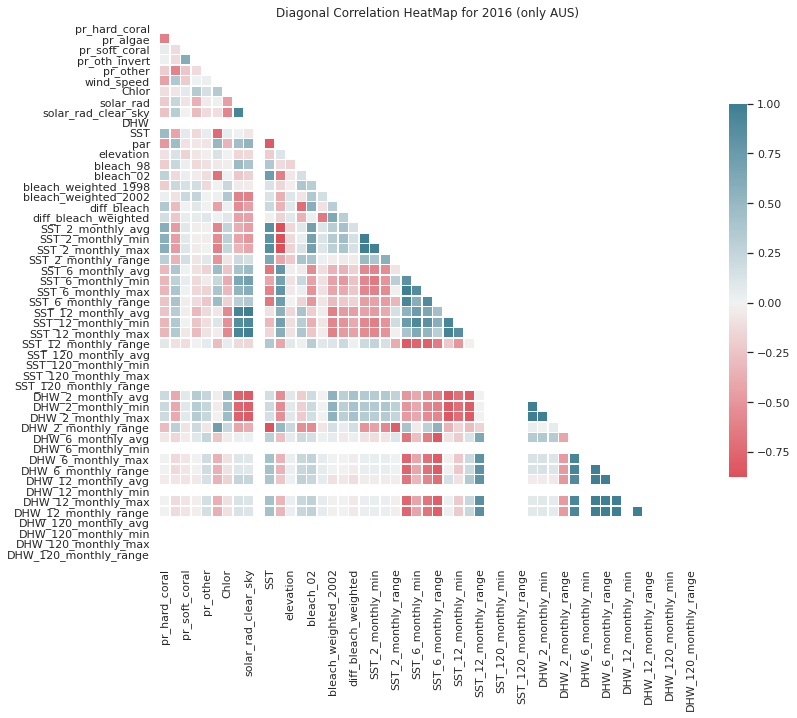

In [75]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_env_ext16.drop(columns = ['year','country', 'geometry', 'clear_rad_solar_2_monthly_avg',
       'clear_rad_solar_2_monthly_min', 'clear_rad_solar_2_monthly_max',
       'clear_rad_solar_2_monthly_range', 'clear_rad_solar_6_monthly_avg',
       'clear_rad_solar_6_monthly_min', 'clear_rad_solar_6_monthly_max',
       'clear_rad_solar_6_monthly_range', 'clear_rad_solar_12_monthly_avg',
       'clear_rad_solar_12_monthly_min', 'clear_rad_solar_12_monthly_max',
       'clear_rad_solar_12_monthly_range', 'wind_2_monthly_avg',
       'wind_2_monthly_min', 'wind_2_monthly_max', 'wind_2_monthly_range',
       'wind_6_monthly_avg', 'wind_6_monthly_min', 'wind_6_monthly_max',
       'wind_6_monthly_range', 'wind_12_monthly_avg', 'wind_12_monthly_min',
       'wind_12_monthly_max', 'wind_12_monthly_range', 'wind_120_monthly_avg',
       'wind_120_monthly_min', 'wind_120_monthly_max',
       'wind_120_monthly_range', 'solar_2_monthly_avg', 'solar_2_monthly_min',
       'solar_2_monthly_max', 'solar_2_monthly_range', 'solar_6_monthly_avg',
       'solar_6_monthly_min', 'solar_6_monthly_max', 'solar_6_monthly_range',
       'solar_12_monthly_avg', 'solar_12_monthly_min', 'solar_12_monthly_max',
       'solar_12_monthly_range']).corr()
keep_interesting_corr(corr,df_keep_env_ext, "2016 (60)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,  fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2016 (only AUS)")

**Take-aways**
Hard corals have:
- Negative corr with wind speed (strange)
- Positive corr with SST (strange)
- Negative corr with PAR (normal)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2017 (only AUS)')

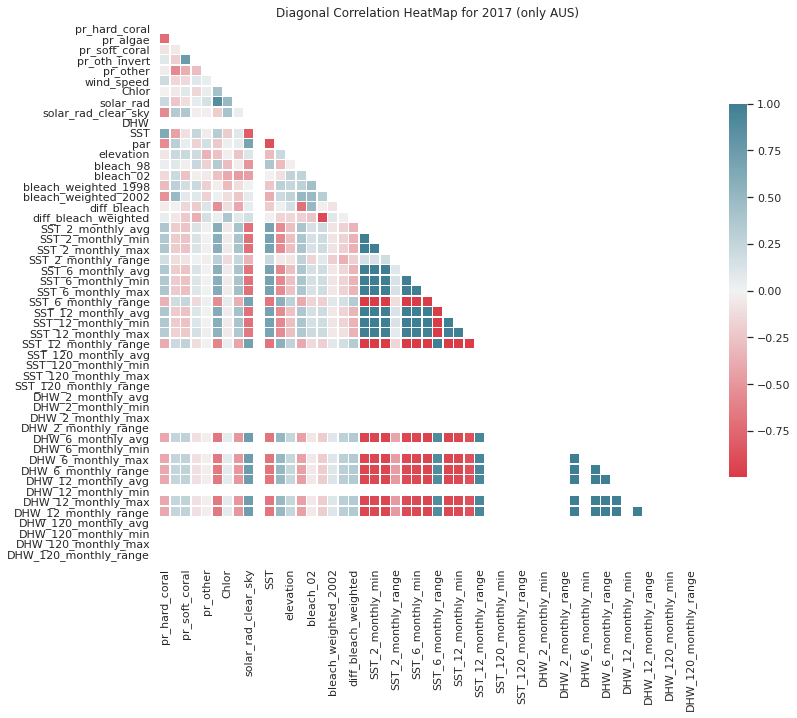

In [76]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_env_ext17.drop(columns = ['year','country', 'geometry', 'clear_rad_solar_2_monthly_avg',
       'clear_rad_solar_2_monthly_min', 'clear_rad_solar_2_monthly_max',
       'clear_rad_solar_2_monthly_range', 'clear_rad_solar_6_monthly_avg',
       'clear_rad_solar_6_monthly_min', 'clear_rad_solar_6_monthly_max',
       'clear_rad_solar_6_monthly_range', 'clear_rad_solar_12_monthly_avg',
       'clear_rad_solar_12_monthly_min', 'clear_rad_solar_12_monthly_max',
       'clear_rad_solar_12_monthly_range', 'wind_2_monthly_avg',
       'wind_2_monthly_min', 'wind_2_monthly_max', 'wind_2_monthly_range',
       'wind_6_monthly_avg', 'wind_6_monthly_min', 'wind_6_monthly_max',
       'wind_6_monthly_range', 'wind_12_monthly_avg', 'wind_12_monthly_min',
       'wind_12_monthly_max', 'wind_12_monthly_range', 'wind_120_monthly_avg',
       'wind_120_monthly_min', 'wind_120_monthly_max',
       'wind_120_monthly_range', 'solar_2_monthly_avg', 'solar_2_monthly_min',
       'solar_2_monthly_max', 'solar_2_monthly_range', 'solar_6_monthly_avg',
       'solar_6_monthly_min', 'solar_6_monthly_max', 'solar_6_monthly_range',
       'solar_12_monthly_avg', 'solar_12_monthly_min', 'solar_12_monthly_max',
       'solar_12_monthly_range']).corr()

keep_interesting_corr(corr,df_keep_env_ext,"2017 (35)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2017 (only AUS)")

**Take-aways**
hard corals have:
- negative corr with solar rad (normal)
- positive corr with SST (strange)
- negative corr with PAR (normal)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for 2018 (only IDN)')

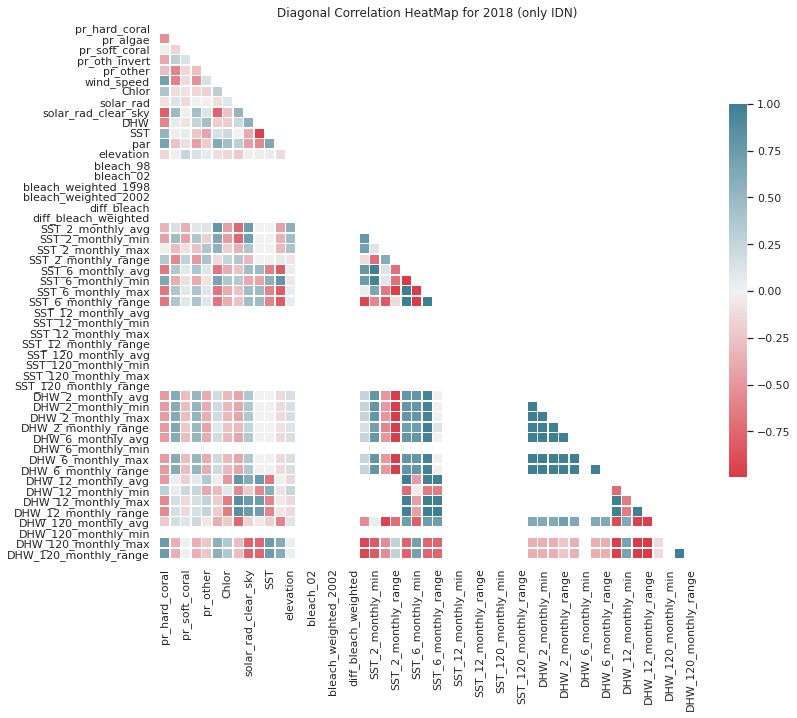

In [77]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_env_ext18.drop(columns = ['year','country', 'geometry', 'clear_rad_solar_2_monthly_avg',
       'clear_rad_solar_2_monthly_min', 'clear_rad_solar_2_monthly_max',
       'clear_rad_solar_2_monthly_range', 'clear_rad_solar_6_monthly_avg',
       'clear_rad_solar_6_monthly_min', 'clear_rad_solar_6_monthly_max',
       'clear_rad_solar_6_monthly_range', 'clear_rad_solar_12_monthly_avg',
       'clear_rad_solar_12_monthly_min', 'clear_rad_solar_12_monthly_max',
       'clear_rad_solar_12_monthly_range', 'wind_2_monthly_avg',
       'wind_2_monthly_min', 'wind_2_monthly_max', 'wind_2_monthly_range',
       'wind_6_monthly_avg', 'wind_6_monthly_min', 'wind_6_monthly_max',
       'wind_6_monthly_range', 'wind_12_monthly_avg', 'wind_12_monthly_min',
       'wind_12_monthly_max', 'wind_12_monthly_range', 'wind_120_monthly_avg',
       'wind_120_monthly_min', 'wind_120_monthly_max',
       'wind_120_monthly_range', 'solar_2_monthly_avg', 'solar_2_monthly_min',
       'solar_2_monthly_max', 'solar_2_monthly_range', 'solar_6_monthly_avg',
       'solar_6_monthly_min', 'solar_6_monthly_max', 'solar_6_monthly_range',
       'solar_12_monthly_avg', 'solar_12_monthly_min', 'solar_12_monthly_max',
       'solar_12_monthly_range']).corr()

keep_interesting_corr(corr,df_keep_env_ext, "2018 (41)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for 2018 (only IDN)")

**Take-aways**
Hard corals:
- positive corr with wind speed (normal)
- negative corr with DHW/Solar (normal)
- Positive corr with SST/PAR (strange)

### Separated by Country

In [78]:
df_data_env_extAUS = df_data_env_ext[df_data_env_ext["country"] == "AUS"]
df_data_env_extIDN = df_data_env_ext[df_data_env_ext["country"] == "IDN"]
df_data_env_extTLS = df_data_env_ext[df_data_env_ext["country"] == "TLS"]
df_data_env_extSLB = df_data_env_ext[df_data_env_ext["country"] == "SLB"]

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for Solomon')

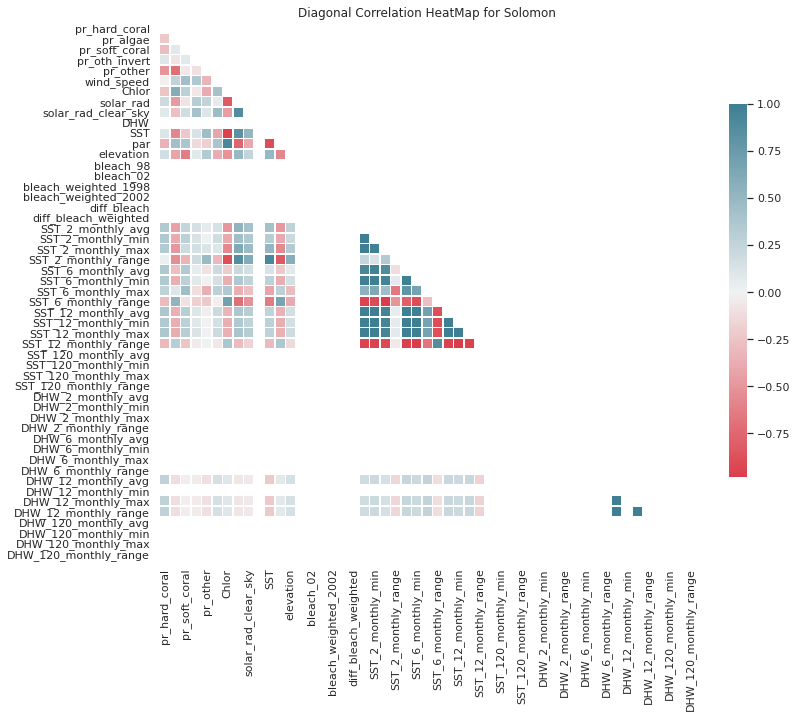

In [79]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_env_extSLB.drop(columns = ['year','country', 'geometry', 'clear_rad_solar_2_monthly_avg',
       'clear_rad_solar_2_monthly_min', 'clear_rad_solar_2_monthly_max',
       'clear_rad_solar_2_monthly_range', 'clear_rad_solar_6_monthly_avg',
       'clear_rad_solar_6_monthly_min', 'clear_rad_solar_6_monthly_max',
       'clear_rad_solar_6_monthly_range', 'clear_rad_solar_12_monthly_avg',
       'clear_rad_solar_12_monthly_min', 'clear_rad_solar_12_monthly_max',
       'clear_rad_solar_12_monthly_range', 'wind_2_monthly_avg',
       'wind_2_monthly_min', 'wind_2_monthly_max', 'wind_2_monthly_range',
       'wind_6_monthly_avg', 'wind_6_monthly_min', 'wind_6_monthly_max',
       'wind_6_monthly_range', 'wind_12_monthly_avg', 'wind_12_monthly_min',
       'wind_12_monthly_max', 'wind_12_monthly_range', 'wind_120_monthly_avg',
       'wind_120_monthly_min', 'wind_120_monthly_max',
       'wind_120_monthly_range', 'solar_2_monthly_avg', 'solar_2_monthly_min',
       'solar_2_monthly_max', 'solar_2_monthly_range', 'solar_6_monthly_avg',
       'solar_6_monthly_min', 'solar_6_monthly_max', 'solar_6_monthly_range',
       'solar_12_monthly_avg', 'solar_12_monthly_min', 'solar_12_monthly_max',
       'solar_12_monthly_range']).corr()
keep_interesting_corr(corr,df_keep_env_ext, "SLB (20)") 
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for Solomon")

**Take-aways**
Hard corals:
- Negative corr with PAR (normal)


Text(0.5, 1.0, 'Diagonal Correlation HeatMap for Timor Leste')

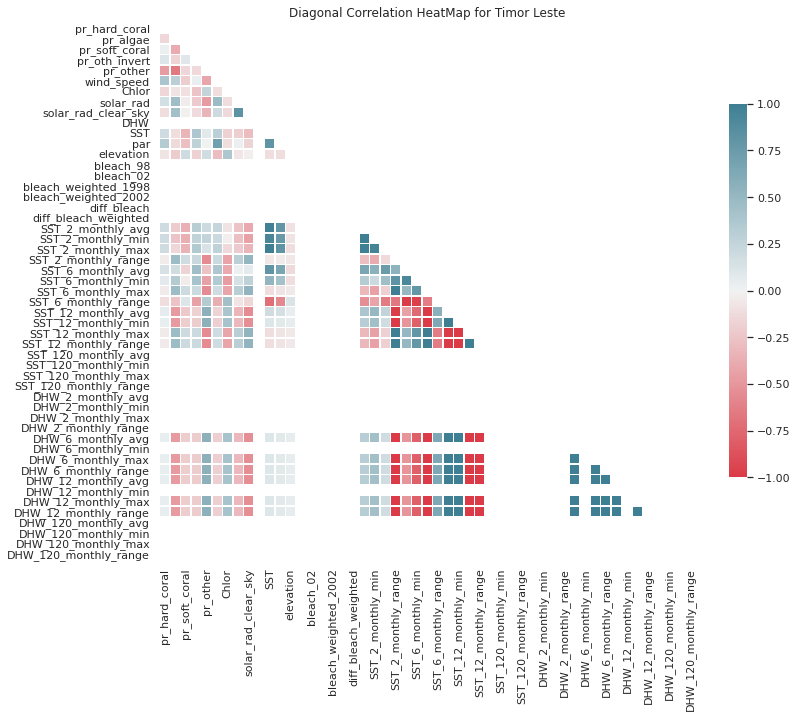

In [80]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_env_extTLS.drop(columns = ['year','country', 'geometry', 'clear_rad_solar_2_monthly_avg',
       'clear_rad_solar_2_monthly_min', 'clear_rad_solar_2_monthly_max',
       'clear_rad_solar_2_monthly_range', 'clear_rad_solar_6_monthly_avg',
       'clear_rad_solar_6_monthly_min', 'clear_rad_solar_6_monthly_max',
       'clear_rad_solar_6_monthly_range', 'clear_rad_solar_12_monthly_avg',
       'clear_rad_solar_12_monthly_min', 'clear_rad_solar_12_monthly_max',
       'clear_rad_solar_12_monthly_range', 'wind_2_monthly_avg',
       'wind_2_monthly_min', 'wind_2_monthly_max', 'wind_2_monthly_range',
       'wind_6_monthly_avg', 'wind_6_monthly_min', 'wind_6_monthly_max',
       'wind_6_monthly_range', 'wind_12_monthly_avg', 'wind_12_monthly_min',
       'wind_12_monthly_max', 'wind_12_monthly_range', 'wind_120_monthly_avg',
       'wind_120_monthly_min', 'wind_120_monthly_max',
       'wind_120_monthly_range', 'solar_2_monthly_avg', 'solar_2_monthly_min',
       'solar_2_monthly_max', 'solar_2_monthly_range', 'solar_6_monthly_avg',
       'solar_6_monthly_min', 'solar_6_monthly_max', 'solar_6_monthly_range',
       'solar_12_monthly_avg', 'solar_12_monthly_min', 'solar_12_monthly_max',
       'solar_12_monthly_range']).corr()
keep_interesting_corr(corr,df_keep_env_ext, "TLS (26)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for Timor Leste")

**Take-aways**

Hard corals have:
- Positive corr with wind speed (normal)
- Positive corr with PAR (strange)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for Australia')

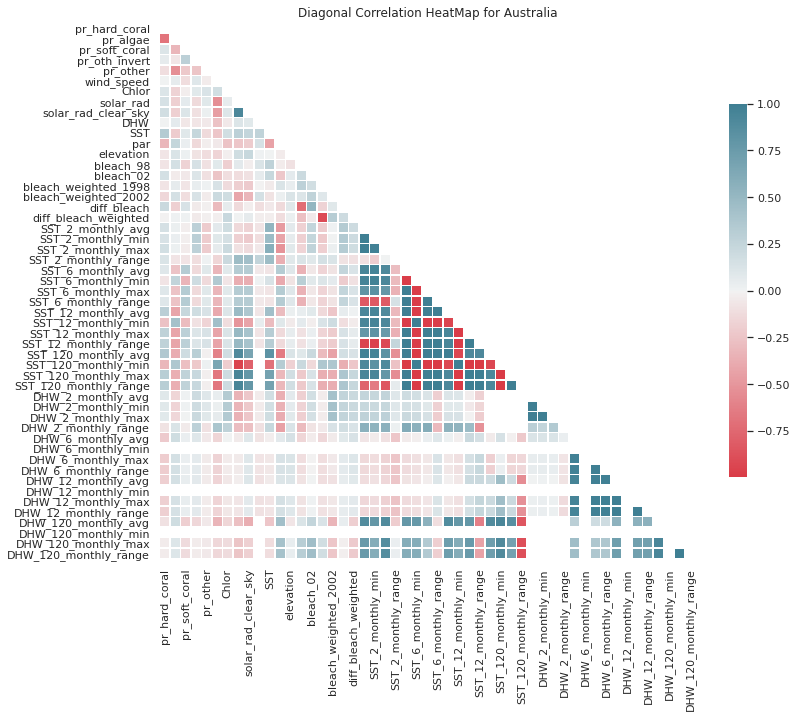

In [81]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df_data_env_extAUS.drop(columns = ['year','country', 'geometry', 'clear_rad_solar_2_monthly_avg',
       'clear_rad_solar_2_monthly_min', 'clear_rad_solar_2_monthly_max',
       'clear_rad_solar_2_monthly_range', 'clear_rad_solar_6_monthly_avg',
       'clear_rad_solar_6_monthly_min', 'clear_rad_solar_6_monthly_max',
       'clear_rad_solar_6_monthly_range', 'clear_rad_solar_12_monthly_avg',
       'clear_rad_solar_12_monthly_min', 'clear_rad_solar_12_monthly_max',
       'clear_rad_solar_12_monthly_range', 'wind_2_monthly_avg',
       'wind_2_monthly_min', 'wind_2_monthly_max', 'wind_2_monthly_range',
       'wind_6_monthly_avg', 'wind_6_monthly_min', 'wind_6_monthly_max',
       'wind_6_monthly_range', 'wind_12_monthly_avg', 'wind_12_monthly_min',
       'wind_12_monthly_max', 'wind_12_monthly_range', 'wind_120_monthly_avg',
       'wind_120_monthly_min', 'wind_120_monthly_max',
       'wind_120_monthly_range', 'solar_2_monthly_avg', 'solar_2_monthly_min',
       'solar_2_monthly_max', 'solar_2_monthly_range', 'solar_6_monthly_avg',
       'solar_6_monthly_min', 'solar_6_monthly_max', 'solar_6_monthly_range',
       'solar_12_monthly_avg', 'solar_12_monthly_min', 'solar_12_monthly_max',
       'solar_12_monthly_range']).corr()
keep_interesting_corr(corr,df_keep_env_ext, "AUS (260)")
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for Australia")

**Take-aways**

Hard corals:
- Positive corr with SST (strange)
- Negative corr with PAR (normal)

Text(0.5, 1.0, 'Diagonal Correlation HeatMap for Indonesia')

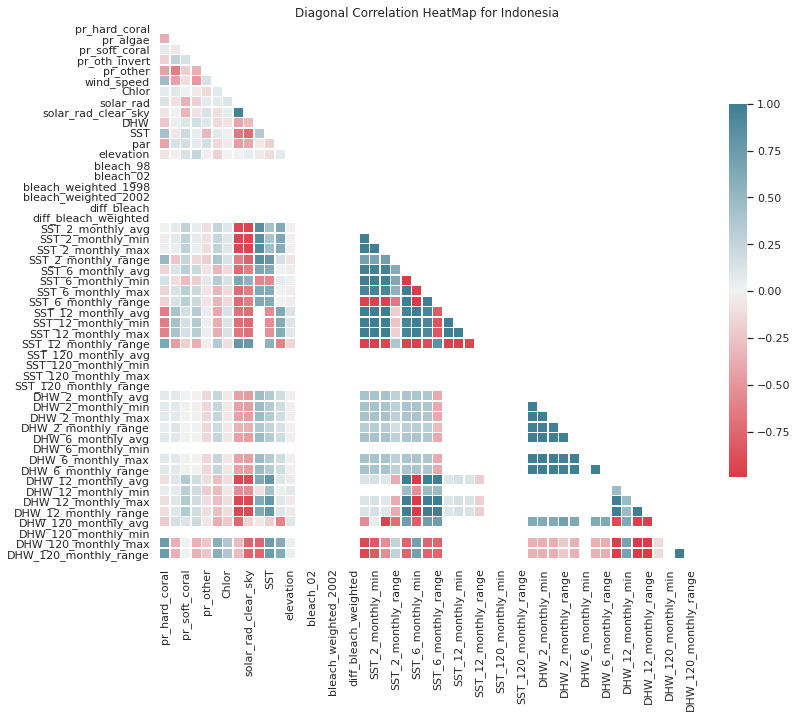

In [82]:
f, ax = plt.subplots(figsize=(12, 12))

corr = df_data_env_extIDN.drop(columns = ['year','country', 'geometry', 'clear_rad_solar_2_monthly_avg',
       'clear_rad_solar_2_monthly_min', 'clear_rad_solar_2_monthly_max',
       'clear_rad_solar_2_monthly_range', 'clear_rad_solar_6_monthly_avg',
       'clear_rad_solar_6_monthly_min', 'clear_rad_solar_6_monthly_max',
       'clear_rad_solar_6_monthly_range', 'clear_rad_solar_12_monthly_avg',
       'clear_rad_solar_12_monthly_min', 'clear_rad_solar_12_monthly_max',
       'clear_rad_solar_12_monthly_range', 'wind_2_monthly_avg',
       'wind_2_monthly_min', 'wind_2_monthly_max', 'wind_2_monthly_range',
       'wind_6_monthly_avg', 'wind_6_monthly_min', 'wind_6_monthly_max',
       'wind_6_monthly_range', 'wind_12_monthly_avg', 'wind_12_monthly_min',
       'wind_12_monthly_max', 'wind_12_monthly_range', 'wind_120_monthly_avg',
       'wind_120_monthly_min', 'wind_120_monthly_max',
       'wind_120_monthly_range', 'solar_2_monthly_avg', 'solar_2_monthly_min',
       'solar_2_monthly_max', 'solar_2_monthly_range', 'solar_6_monthly_avg',
       'solar_6_monthly_min', 'solar_6_monthly_max', 'solar_6_monthly_range',
       'solar_12_monthly_avg', 'solar_12_monthly_min', 'solar_12_monthly_max',
       'solar_12_monthly_range']).corr()

keep_interesting_corr(corr,df_keep_env_ext, "IDN (110)") 
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(10, 220, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap for Indonesia")

**Take-aways**

Hard corals have:
- Positive corr with wind speed

In [83]:
frame_corr_env_ext = pd.concat(df_keep_env_ext, axis = 1)

In [84]:
classes = frame_corr_env_ext.columns

In [85]:
strs = ["pr_hard" for x in range(len(frame_corr_env_ext.columns))]

38

In [102]:
frame_corr_env_ext = frame_corr_env_ext.iloc[12:]

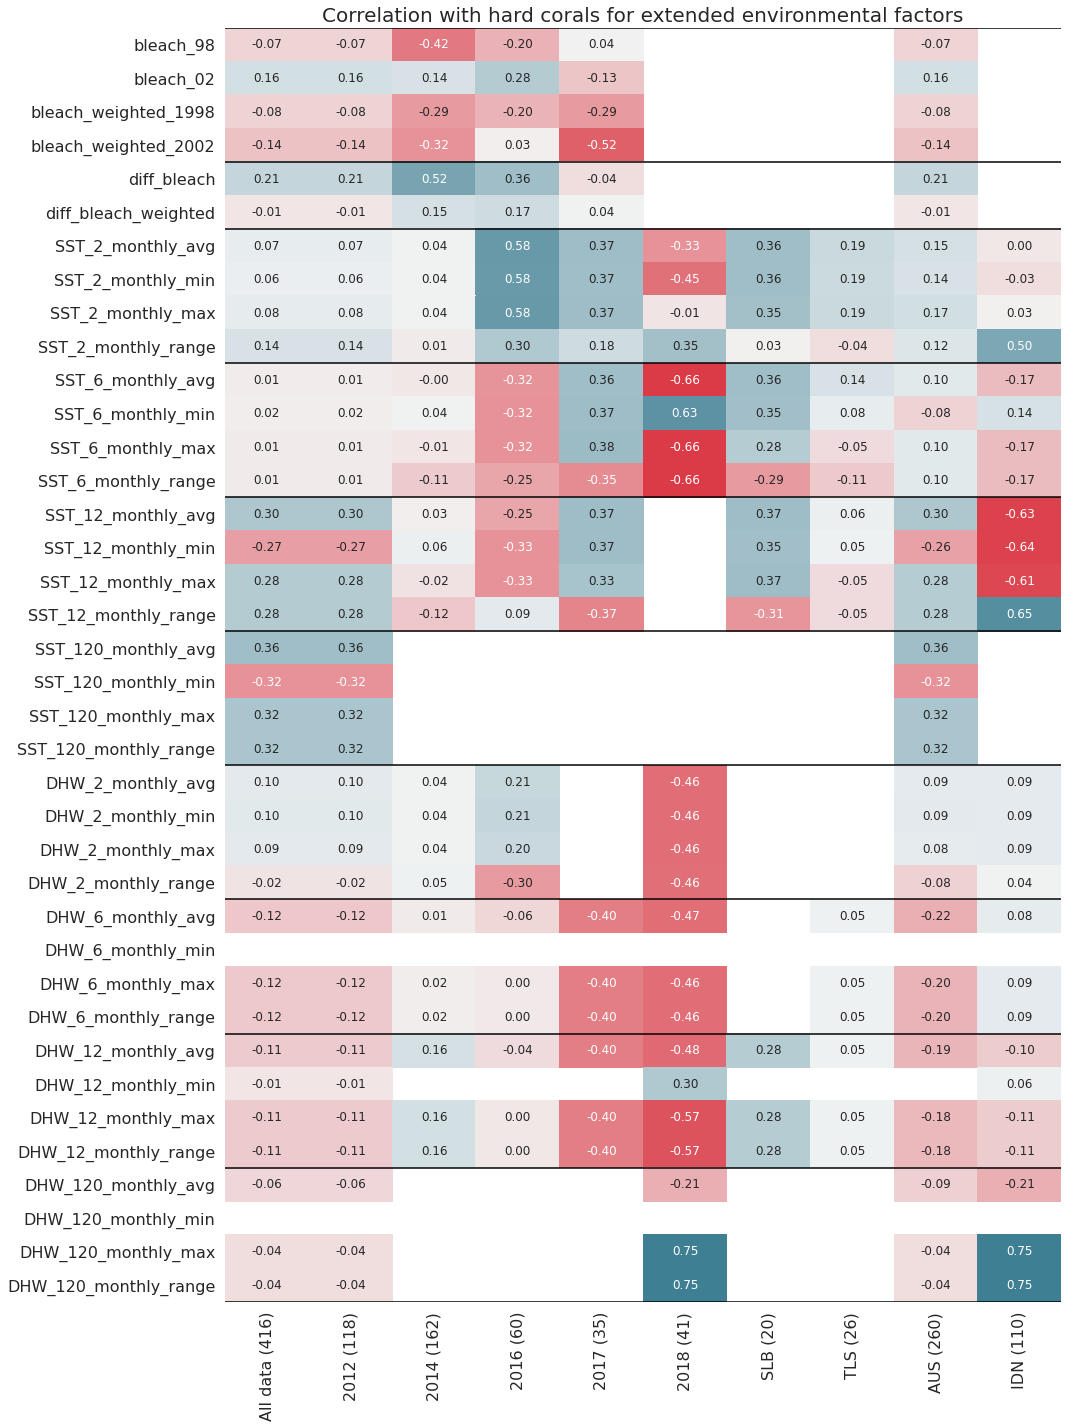

In [118]:
plt.figure(figsize=(15,20))
yticks = frame_corr_env_ext.index
ok_len = len(frame_corr_env_ext.index)
keptticks = yticks[::int(len(yticks)/ok_len)]
yticks = ['' for y in yticks]
yticks[::int(len(yticks)/ok_len)] = keptticks

xticks = frame_corr_env.columns
#xticks = strs
keptticks = xticks[::int(len(xticks)/10)]
xticks = ['' for y in xticks]
xticks[::int(len(xticks)/10)] = keptticks
cmap = sns.diverging_palette(10, 220, as_cmap=True)

ax = sns.heatmap(frame_corr_env_ext,cmap = cmap, linewidth=0,yticklabels=yticks,xticklabels=xticks,annot=True, cbar = False ,fmt='.2f')
ax.hlines([0,4, 6, 10, 14,18, 22, 26, 30, 34,38], colors = "black",*ax.get_xlim())

# This sets the yticks "upright" with 0, as opposed to sideways with 90.
plt.yticks(rotation=0,fontsize = 16) 
plt.xticks(rotation=90,fontsize = 16) 
plt.title("Correlation with hard corals for extended environmental factors",fontsize = 20)
plt.tight_layout()
plt.show()



## Focus on Australia

In [156]:
df_IND_diff = pd.read_csv("../Data/Intermediate_csv/diff_IND.csv")
df_AUS_diff = pd.read_csv("../Data/Intermediate_csv/diff_AUS.csv")

In [158]:
df_IND_diff

transectid  pr_hard_coral  pr_soft_coral  pr_algae  pr_oth_invert  \
0        32001        0.03670        0.02050   0.80530         0.0135   
1        32002        0.09610        0.01760   0.67300         0.0279   
2        32003        0.14055        0.01560   0.75860         0.0113   
3        32004        0.12730        0.03320   0.76000         0.0670   
4        32005        0.12290        0.02070   0.65400         0.0891   
5        32006        0.11990        0.04740   0.66310         0.0597   
6        32007        0.09180        0.02260   0.76880         0.0572   
7        32008        0.15340        0.01320   0.72780         0.0662   
8        32009        0.11640        0.00420   0.65820         0.0370   
9        32010        0.03730        0.00720   0.64900         0.0157   
10       32011        0.08150        0.02380   0.61420         0.0328   
11       32012        0.05870        0.05040   0.54380         0.0512   
12       32022        0.06640        0.03060   0.73740         0.0368   
13       32023        0.11480        0.06580   0.45410         0.0307   
14       32024        0.11475        0.02215   0.70840         0.0263   
15       32025        0.12930        0.06010   0.70910         0.0764   
16       32026        0.15890        0.04090   0.69385         0.0729   
17       32027        0.09910        0.03140   0.76780         0.0747   
18       32029        0.13400        0.03880   0.64710         0.1535   
19       32030        0.17655        0.02515   0.73545         0.0522   
20       32031        0.12580        0.01210   0.76220         0.0392   
21       32032        0.13500        0.09760   0.68010         0.0460   
22       32034        0.16460        0.02070   0.69170         0.0350   
23       32035        0.12260        0.05500   0.70960         0.0336   
24       33001        0.30030        0.01880   0.49400         0.0282   
25       33002        0.26410        0.01450   0.55000         0.0186   
26       33004        0.29430        0.02350   0.52640         0.0157   
27       33005        0.21330        0.03300   0.65520         0.0365   
28       33006        0.30380        0.08480   0.57220         0.0210   
29       33007        0.26680        0.06060   0.63750         0.0119   
30       33008        0.27530        0.06950   0.52400         0.0259   
31       33009        0.23530        0.01900   0.50800         0.0173   
32       33010        0.24900        0.01690   0.55070         0.0299   
33       33011        0.19500        0.03220   0.72630         0.0311   
34       33012        0.21300        0.00820   0.71780         0.0367   
35       33013        0.23620        0.02130   0.48750         0.0143   
36       33014        0.29840        0.02500   0.54410         0.0211   
37       33016        0.28680        0.02760   0.64640         0.0137   
38       33017        0.34960        0.02540   0.58130         0.0221   
39       33018        0.20010        0.01840   0.69480         0.0292   
40       33019        0.19070        0.02480   0.67100         0.0394   

    pr_other  year                               geometry   others  diff_hard  \
0    0.12400  2018            POINT (124.628786 1.414781)  0.13750   -0.00360   
1    0.18500  2018             POINT (124.59815 1.414152)  0.21290    0.00780   
2    0.07400  2018           POINT (110.441772 -5.803946)  0.08530    0.11715   
3    0.01240  2018              POINT (124.8956 1.642526)  0.07940   -0.02870   
4    0.11320  2018            POINT (124.924026 1.681424)  0.20230    0.04250   
5    0.11010  2018             POINT (124.95142 1.724209)  0.16980    0.00800   
6    0.05980  2018            POINT (125.082394 1.879782)  0.11700   -0.00430   
7    0.03940  2018            POINT (125.081214 1.878212)  0.10560    0.04280   
8    0.18400  2018             POINT (125.062408 1.85095)  0.22100    0.00070   
9    0.29080  2018            POINT (125.146803 1.836848)  0.30650    0.02820   
10   0.24770  2018              POINT (125.130